<h1 style="background-color:#34eb74; color:white"> Exploratory Data Analysis for Bull_Bear_Market </h1>

The Market Growth Prediction project aims to forecast market growth rates in the construction industry, focusing on areas where Zurn Elkay water solutions operates. By leveraging various data sources, including economic indicators, competitor data, customer reviews, and company-specific data, the project aims to provide valuable insights and predictions to guide business strategy and decision-making.

## Why we do it?
- **Strategic Planning**: Identify Opportunities: Understand market trends and dynamics to identify growth opportunities.
- **Competitive Advantage**: Gain insights into competitor performance and market positioning.
- **Data-Driven Decisions**: Risk Mitigation: Anticipate market changes and mitigate risks associated with market fluctuations.
- **Optimize Resources**: Allocate resources efficiently based on data-driven insights.
- **Customer Experience Enhancement**: Personalized Marketing: Tailor marketing strategies based on customer feedback and preferences.
- **Improve Customer Satisfaction**: Address customer needs and enhance satisfaction through personalized experiences.

| **Traditional Tech**                 | **Description**                                                                                     |
|--------------------------------------|-----------------------------------------------------------------------------------------------------|
| Statistical Analysis                 | Descriptive and inferential statistics: Mean, median, mode, standard deviation, hypothesis testing, correlation analysis, etc. |
| Regression Models                    | Linear Regression, Time Series Analysis                                                                   |
| Data Visualization                   | Charts and Graphs: Bar charts, line charts, pie charts, etc.                                           |
| Market Research Surveys              | Customer Surveys, Competitor Analysis                                                                     |
| Financial Analysis                   | Financial Ratios, ROI Analysis                                                                            |

---

| **Novel Tech**                       | **Advantages**                                                                                      |
|--------------------------------------|-----------------------------------------------------------------------------------------------------|
| Advanced Machine Learning Algorithms | Improved accuracy, flexibility                                                                        |
| Natural Language Processing (NLP)    | Customer insights, personalized marketing                                                              |
| Interactive Streamlit App            | User engagement, real-time updates, dynamic visualization                                              |
                                                          |

---

| **Why We Are Using Novel Tech**      | **Advantages**                                                                                      |
|--------------------------------------|-----------------------------------------------------------------------------------------------------|
| Enhanced Accuracy and Efficiency     | Improved accuracy and efficiency compared to traditional methods                                      |
| Personalized Insights                | NLP and interactive technologies allow for personalized insights and recommendations                 |
| Improved User Experience             | Interactive Streamlit app and RAG chatbot enhance user engagement and satisfaction                    |
| Real-Time Updates and Dynamic Visualization | Real-time updates and dynamic visualization of predictions and insights                               |



<h1 style="background-color:#34eb74; color:white"> Standard Package Import </h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator
import seaborn as sns
import math
import calendar

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



%matplotlib inline

## <h1 style="background-color:#34eb74; color:white"> Standard Functions used throughout the project </h1>

In [ ]:
def check_null(df):
    """
    Return percentage of rows with missing data
    """
    results = df.isnull().sum() * 100 / len(df)
    print(results)

def check_duplicates(df, subset=None):
    """
    Return if there are duplicates rows in the data

    df : DataFrame under consideration
    subset: Optional list of feature neams upon which duplicates are identified

    Output: If duplicate is 0, there are no duplicates
    """
    if subset is not None:
        duplicates = df[df.duplicated(subset=subset, keep=False)]
        if len(duplicates) == 0:
            print("No duplicates found based on the specified subset.")
        else:
            print("Duplicates found based on the specified subset:")
            print(duplicates)
    else:
        duplicates_count = df.duplicated(keep=False).sum()
        if duplicates_count == 0:
            print("No duplicates found.")
        else:
            print(f"Total duplicates found: {duplicates_count}")


def rename_column(df, old_name, new_name):
    '''
    Output: column name is changed
    '''
    return df.rename(columns={old_name:new_name}, inplace= True)

def to_float(df, feature_name):
    """
    Output: Remove punctaution from string and convert to float if feature is string otherwise convert to float
    """
    if df[feature_name].dtype == "object":
        df[feature_name] =  df[feature_name].str.replace(",","").astype(float)
    else:
         df[feature_name] =  df[feature_name].astype(float)

def to_numeric(df, feature_name):
  # Replace non-numeric values like ".." with NaN
  df[feature_name] = pd.to_numeric(df[feature_name], errors='coerce')
  df[feature_name].dropna(inplace=True)
  df[feature_name].round(2).astype(float)

def year2019_or_above(df, feature_name):
    '''
    Output : Store data later than 2019 only
    '''
    df = df.query(f"{feature_name}>= 2019")


def to_date(df, feature_name):
  '''
  Output: Convert feature to datatime
  '''
  df[feature_name] = pd.to_datetime(df[feature_name])
  return df.info()

def add_features(df,feature_name_modify):
  df["Year"] = df[feature_name_modify].dt.year
  df["Month"] = df[feature_name_modify].dt.month
  df["Day"] = df[feature_name_modify].dt.month
  return df.head(2)

def fill_na_mean(df, feature_name):
  df[feature_name].fillna(df[feature_name].mean(), inplace=True)

def plot_ts(df, X, y, hue=None):
    sns.set_style("white") # set style of plot

    fig, ax = plt.subplots(figsize=(10,6))

    y_mil = df[y]//1000000

    ax = sns.lineplot(data=df, x=X, y=y_mil, hue=df.columns[0], errorbar=None, markers=True) # do not show confidence intervals

    # add text on chart for top 1 only
    highest_value = df[y].max()
    highest_year = df.loc[df[y].idxmax(), X]

    # Annotate top 3 values on the plot
    ax.annotate(f'Highest value is {highest_value:,.0f}M\nYear: {highest_year}',
                xy=(highest_year, highest_value//1000000), xycoords='data',
                xytext=(0,10), textcoords='offset points',
                fontsize=10)

    ax.set_title(f"Trend for {df.columns[0]} \n highest growth is in year {highest_year} of ${highest_value//1000000}M")
    ax.set_ylabel("USD")
    ax.legend(title = df.columns[0], loc="upper left", bbox_to_anchor=(1, 1)) # add legend outside the plot
    sns.despine() # remove grids

    # # format y axis to represent values in Millions
    # ax.set_yticklabels([f"{int(y)}M" for y in ax.get_yticks()])

    # Format y-axis ticks to represent values in millions (M)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}M'))

    # Set y-axis tick locators
    ax.set_yticks(ax.get_yticks())

    plt.tight_layout()
    plt.show()

def plot_bar(df,groupby_featureName,X,y, hue=None):
    regions = df[groupby_featureName].unique()
    if len(regions) % 3 == 0:
        rows = len(regions) // 3
        cols = 3
    else:
        rows = len(regions) // 3 + 1
        cols = len(regions) % 3

    fig, axes = plt.subplots(rows,cols, figsize=(15,10), sharey = True)

    for i, region in enumerate(regions):
        row_idx = i // 3
        col_idx = i % 3
        region_data = df[df[groupby_featureName] == region]
        region_total = region_data[y].sum()

        # find highest performing section in the region
        highest_value = region_data[y].max()
        highest_year = region_data.loc[region_data[y].idxmax(),X]
        highest_section = region_data.loc[region_data[y].idxmax(), hue]

        sns.barplot(data = region_data, x = X , y = y, hue = hue , ax=axes[row_idx, col_idx], errorbar = None)
        axes[row_idx, col_idx].set_title(f"Total for {region} is USD {region_total/1000000:.2f}M", fontsize=10)

        axes[row_idx, col_idx].annotate(f"Highest value is {highest_value:,.0f}M\nYear: {highest_year}\nSection: {highest_section}",
                        xy=(7,highest_value), xycoords='data',
                        xytext=(0, 0), textcoords="offset points", fontsize=10, ha='center')

        #remove y axis labels except 1st chart
        if col_idx != 0:
            axes[row_idx, col_idx].set_ylabel("")
        if row_idx != rows - 1 or col_idx != cols - 1:
            axes[row_idx, col_idx].legend(title = df.columns[0], loc="upper left")

    plt.tight_layout()
    plt.show()

def plot_pie(df,groupby_featureName1, y):
    df_ind = df.groupby(groupby_featureName1)[y].sum()
    # df_ind = df_ind.reset_index()
    plt.pie(df_ind, labels = df_ind.index, autopct="%1.1f%%", textprops={'wrap':True})
    plt.show()

def plot_box(df, y, X = None, ax=None):
  '''
  x  is optional
  y : feature_name
  data : dataframe
  '''
  sns.boxplot(data = df, x = X, y = y, ax = ax,
              notch=True,
              showcaps=True,
              flierprops={"marker":"x"},
              boxprops={'facecolor':(0.3,0.5,0.7,0.5)},
              medianprops={"color": "r", "linewidth":2},
              showmeans = True)
  plt.xlabel(f"{X}")
  plt.ylabel(f"{y}")
  plt.title(f"{y} price trend")

def find_outliers(df, feature_name):
  q1 = df[feature_name].quantile(0.25)
  q3 = df[feature_name].quantile(0.75)
  iqr = q3 - q1
  upper_bound = q3 + 1.5 * iqr
  # lower_bound = q1 - 1.5 * iqr
  #df = df[(df[feature_name] <= upper_bound)]
  df.drop(df[df[feature_name] > upper_bound].index, inplace=True)

def plot_ts_stocks(df,daterange,feature_name1):
  sns.lineplot(data = df, x = daterange, y = feature_name1)
  plt.title(f" Trend {feature_name1}")
  plt.xlabel(f'{daterange}')
  plt.ylabel(f'{feature_name1}')
  plt.show()


def adf_test(df, feature_name):
  '''
  Check wether time series is stationary or not
  '''
  results = adfuller(df[feature_name], autolag = 'AIC')
  print("ADF statistics: {:.2f}.format(results[0])")
  print("p-values: {:.2f}.format(results[1])")
  print("Critical Values: ")
  for key, value in results[4].items():
    print("\t{key}: {value:.2f}")
    if results[1] <= 0.05:
      print("The time series is stationary")
    else:
      print("The time series in non-statioanry")

def plot_acf_pacf(df,feature_name):
  fig, ax = plt.subplots(2,1,figsize=(20,6))
  plot_acf(df[feature_name], ax = ax[0])
  results_acf = acf(df[feature_name])
  print(f"ACF results are: {results_acf} \n")

  plot_pacf(df[feature_name] , ax = ax[1])
  results_pacf = pacf(df[feature_name])
  print(f"PACF results are: {results_pacf}, \n")
  # Set custom x-axis ticks
  for i in range(2):
    ax[i].set_xticks(np.arange(0, 100, step=2))

  plt.show()

def plot_ts_economy(df,daterange ,feature_name1):
  plt.figure(figsize=(15,6))
  sns.lineplot(data = df, x = daterange,y = feature_name1, errorbar = None)

  # Set y-axis tick formatter to display integer values
  plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

  # reverse y axis
  #plt.gca().invert_yaxis()

  years = df[daterange].astype(int).unique()  # Get unique integer years from the 'Time' column
  plt.gca().xaxis.set_major_locator(FixedLocator(years))  # Set the tick locations to the integer years

  # find max dollar and highest year
  max_int = df[feature_name1].max()
  max_yr = df.loc[df[feature_name1].idxmax(),daterange]

  # Write on chart
  plt.annotate(f'Highest : $ {max_int:.2f} in {int(max_yr)}',
              xy = (max_yr, 5),
              xytext = (max_yr-10,5)
              )

# find max dollar and highest year
  min_int = df[feature_name1].min()
  min_yr = df.loc[df[feature_name1].idxmax(),daterange]

  # Write on chart
  plt.annotate(f'Highest : $ {min_int:.2f} in {int(min_yr)}',
              xy = (min_yr, 5),
              xytext = (min_yr-10,2)
              )
  plt.xticks(rotation=45, ha='right')
  plt.show()

def determine_economy_status(df):
    status = []
    for i in range(len(df) - 1):
        current_row = df.iloc[i + 1]  # Adjusted to start from the second row
        previous_row = df.iloc[i]

        if current_row["Stainless Steel Price USD"] > previous_row["Stainless Steel Price USD"] and \
            current_row["World_GDP"] > previous_row["World_GDP"] and \
            current_row["USA_GDP"] > previous_row["USA_GDP"] and \
            current_row["Interest Rate"] > previous_row["Interest Rate"]:
            status.append("Bullish")
        elif current_row["Stainless Steel Price USD"] < previous_row["Stainless Steel Price USD"] and \
            current_row["World_GDP"] < previous_row["World_GDP"] and \
            current_row["USA_GDP"] < previous_row["USA_GDP"] and \
            current_row["Interest Rate"] < previous_row["Interest Rate"]:
            status.append("Bearish")
        else:
            status.append("Neutral")

    # Add the status for the last row (no next row to compare with)
    status.append(np.nan)

    return status

## <h1 style="background-color:#34eb74; color:white"> Data Description </h1>



### Market Segment Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read data
data_dir = "/content/drive/MyDrive/AI Course with UC Berkely/capstone"

#market data
market_sgement_df = pd.read_csv(f"{data_dir}/ByMarketSegment.csv")
state_df = pd.read_csv(f"{data_dir}/ByState.csv")
regionWorktype_df = pd.read_csv(f"{data_dir}/ByRegionWorkType.csv")
regionConstType_df = pd.read_csv(f"{data_dir}/ByRegionConstructionType.csv")
ind_state_df = pd.read_csv(f"{data_dir}/ByIndustryState.csv")
ind_store_type_df = pd.read_csv(f"{data_dir}/ByIndustryStoryType.csv")
ind_worktype_df = pd.read_csv(f"{data_dir}/ByIndustryWorkType.csv")
ind_consttype_df = pd.read_csv(f"{data_dir}/ByIndsutryConstructionType.csv")
regionIndBld_df = pd.read_excel(f"{data_dir}/ByRegionIndBld.xlsx", sheet_name = "MasterData" )
ind_consttype_df = pd.read_csv(f"{data_dir}/ByIndsutryConstructionType.csv")

tbl = [
    (market_sgement_df,"By Market Segment"),
    (state_df,"By State"),
    (regionWorktype_df,"By Region Work Type"),
    (regionConstType_df,"ByRegion Construction Type"),
    (ind_state_df,"By Industry State Type"),
    (ind_store_type_df,"By Industry Store Type"),
    (ind_worktype_df,"ByIndustry Work Type"),
    (regionIndBld_df,"ByRegion Industry Buildings")
    ]


Using stored files on Downloads

In [ ]:
# # Read data
# data_dir = r"C:\Users\SHARM\Downloads\capstone\DataSet"

# #market data
# market_sgement_df = pd.read_csv(f"{data_dir}ByMarketSegment.csv")
# state_df = pd.read_csv(f"{data_dir}/ByState.csv")
# regionWorktype_df = pd.read_csv(f"{data_dir}/ByRegionWorkType.csv")
# regionConstType_df = pd.read_csv(f"{data_dir}/ByRegionConstructionType.csv")
# ind_state_df = pd.read_csv(f"{data_dir}/ByIndustryState.csv")
# ind_store_type_df = pd.read_csv(f"{data_dir}/ByIndustryStoryType.csv")
# ind_worktype_df = pd.read_csv(f"{data_dir}/ByIndustryWorkType.csv")
# ind_consttype_df = pd.read_csv(f"{data_dir}/ByIndsutryConstructionType.csv")
# regionIndBld_df = pd.read_excel(f"{data_dir}/ByRegionIndBld.xlsx", sheet_name = "MasterData" )
# ind_consttype_df = pd.read_csv(f"{data_dir}/ByIndsutryConstructionType.csv")

# tbl = [
#     (market_sgement_df,"By Market Segment"),
#     (state_df,"By State"),
#     (regionWorktype_df,"By Region Work Type"),
#     (regionConstType_df,"ByRegion Construction Type"),
#     (ind_state_df,"By Industry State Type"),
#     (ind_store_type_df,"By Industry Store Type"),
#     (ind_worktype_df,"ByIndustry Work Type"),
#     (regionIndBld_df,"ByRegion Industry Buildings")
#     ]


### Economy data

In [ ]:
# # economny data saved on computer
# data_dir = r"C:\Users\SHARM\Downloads\capstone"

# interests_df = pd.read_csv(f"{data_dir}/Real Interest rates.csv")
# gdp_df = pd.read_csv(f"{data_dir}/GDP growth.csv")
# stainless_steel_df = pd.read_csv(f"{data_dir}/StainlessSteel.csv")

Using google colab

In [ ]:
interests_df = pd.read_csv("/content/drive/MyDrive/AI Course with UC Berkely/capstone/Real Interest rates.csv")
gdp_df = pd.read_csv("/content/drive/MyDrive/AI Course with UC Berkely/capstone/GDP growth.csv")
stainless_steel = pd.read_csv("/content/drive/MyDrive/AI Course with UC Berkely/capstone/StainlessSteel.csv")

### Financial data

In [ ]:
company_financials_df = pd.read_csv(f"{data_dir}/ZWS.csv")

## Market Data EDA

In [ ]:
for df, name in tbl:
    print(df.head())

  MarketSegment  Year     Measure
0        Retail  2022  19,484,007
1        Retail  2021  14,988,710
2        Retail  2020  12,601,203
3        Retail  2019  16,603,396
4        Retail  2018  17,112,813
     State  Year  Measure
0  Wyoming  2024   428359
1  Wyoming  2023  1334616
2  Wyoming  2022  1736730
3  Wyoming  2021  1465314
4  Wyoming  2020   917622
               Region WorkType  Year   Measure
0  East North Central  Private  2024  13766121
1  East North Central  Private  2023  66559975
2  East North Central  Private  2022  69416687
3  East North Central  Private  2021  54285015
4  East North Central  Private  2020  47527864
               Region  ConstructionType  Year   Measure
0  East North Central  New Construction  2024  13125524
1  East North Central  New Construction  2023  59012411
2  East North Central  New Construction  2022  64536105
3  East North Central  New Construction  2021  53397630
4  East North Central  New Construction  2020  44965012
                 Indus

In [ ]:
for df, name in tbl:
    print(f"Data is {name}")
    check_null(df)
    print("\n")

Data is By Market Segment
MarketSegment    0.0
Year             0.0
Measure          0.0
dtype: float64


Data is By State
State      0.0
Year       0.0
Measure    0.0
dtype: float64


Data is By Region Work Type
Region      0.0
WorkType    0.0
Year        0.0
Measure     0.0
dtype: float64


Data is ByRegion Construction Type
Region              0.0
ConstructionType    0.0
Year                0.0
Measure             0.0
dtype: float64


Data is By Industry State Type
Industry    0.0
State       0.0
Year        0.0
Measure     0.0
dtype: float64


Data is By Industry Store Type
Industry      0.000000
StoryType    19.098143
Year          0.000000
Measure       0.000000
dtype: float64


Data is ByIndustry Work Type
Industry       0.0
Work Type      0.0
Switch Time    0.0
Measure        0.0
dtype: float64


Data is ByRegion Industry Buildings
Region             0.0
IndustrySegment    0.0
Buildings          0.0
YEAR               0.0
SAREA              0.0
SUNITS             0.0
SVAL00    

In [ ]:
ind_store_type_df['StoryType'].fillna("1 Story", inplace=True)

In [ ]:
# Find the index of the tuple containing the DataFrame with name "By Industry Store Type"
index_to_replace = next(index for index, (df, name) in enumerate(tbl) if name == "By Industry Store Type")

# Replace the tuple at the found index with the new DataFrame
tbl[index_to_replace] = (ind_store_type_df, "By Industry Store Type")


Among all data sets for Industry, We have 19% of mising data for story type for industry. Upon reviewing,we find, there are 0 story i.e same level and are restaurants

In [ ]:
for df, name in tbl:
    print(f"Data is {name}")
    check_null(df)
    print("\n")

Data is By Market Segment
MarketSegment    0.0
Year             0.0
Measure          0.0
dtype: float64


Data is By State
State      0.0
Year       0.0
Measure    0.0
dtype: float64


Data is By Region Work Type
Region      0.0
WorkType    0.0
Year        0.0
Measure     0.0
dtype: float64


Data is ByRegion Construction Type
Region              0.0
ConstructionType    0.0
Year                0.0
Measure             0.0
dtype: float64


Data is By Industry State Type
Industry    0.0
State       0.0
Year        0.0
Measure     0.0
dtype: float64


Data is By Industry Store Type
Industry     0.0
StoryType    0.0
Year         0.0
Measure      0.0
dtype: float64


Data is ByIndustry Work Type
Industry       0.0
Work Type      0.0
Switch Time    0.0
Measure        0.0
dtype: float64


Data is ByRegion Industry Buildings
Region             0.0
IndustrySegment    0.0
Buildings          0.0
YEAR               0.0
SAREA              0.0
SUNITS             0.0
SVAL00             0.0
Measure    

Check for duplicates in data

In [ ]:
for df, name in tbl:
    print(f"duplicates in data {name}")
    check_duplicates(df, subset=None)
    print("\n")

duplicates in data By Market Segment
No duplicates found.


duplicates in data By State
No duplicates found.


duplicates in data By Region Work Type
No duplicates found.


duplicates in data ByRegion Construction Type
No duplicates found.


duplicates in data By Industry State Type
No duplicates found.


duplicates in data By Industry Store Type
No duplicates found.


duplicates in data ByIndustry Work Type
No duplicates found.


duplicates in data ByRegion Industry Buildings
No duplicates found.




Convert target column Measure to float

In [ ]:
for df, name in tbl:
    to_float(df, "Measure")

Rename Columns to ensure consistency

In [ ]:
# update table
index_to_replace1 = next(inx for inx, (df,name) in enumerate(tbl) if name == "ByIndustry Work Type")
index_to_replace2 = next(inx for inx, (df,name) in enumerate(tbl) if name == "ByRegion Industry Buildings")

# rename column
rename_column(ind_worktype_df, "Switch Time","Year")
rename_column(regionIndBld_df, "YEAR","Year")


tbl[index_to_replace1] = (ind_worktype_df,"ByIndustry Work Type")
tbl[index_to_replace2] = (regionIndBld_df,"ByRegion Industry Buildings")



Store recent data only

In [ ]:
year2019_or_above(regionIndBld_df, 'Year')

Visualize data

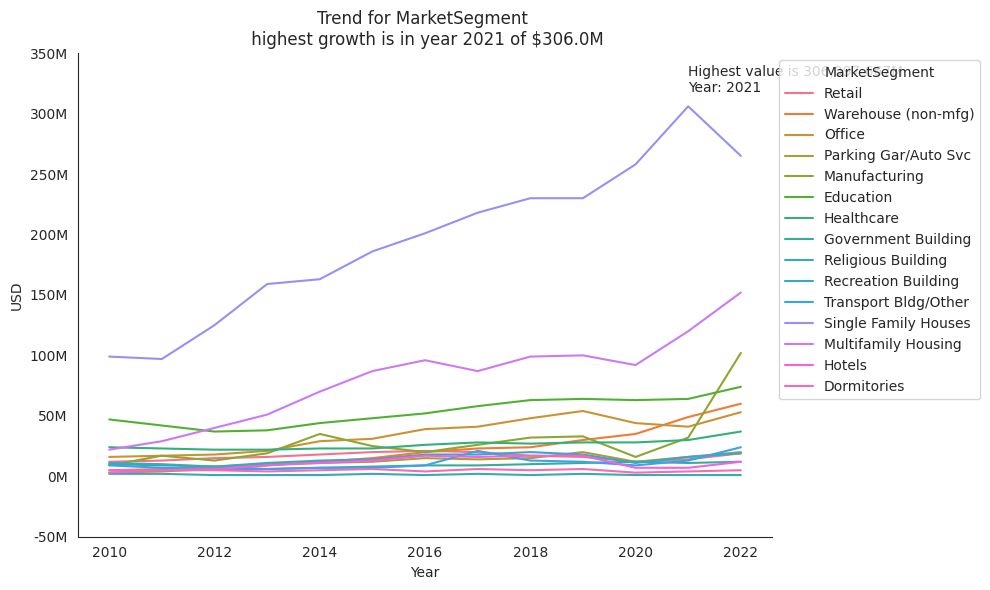

<ipython-input-3-005cd6d29d92>:109: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


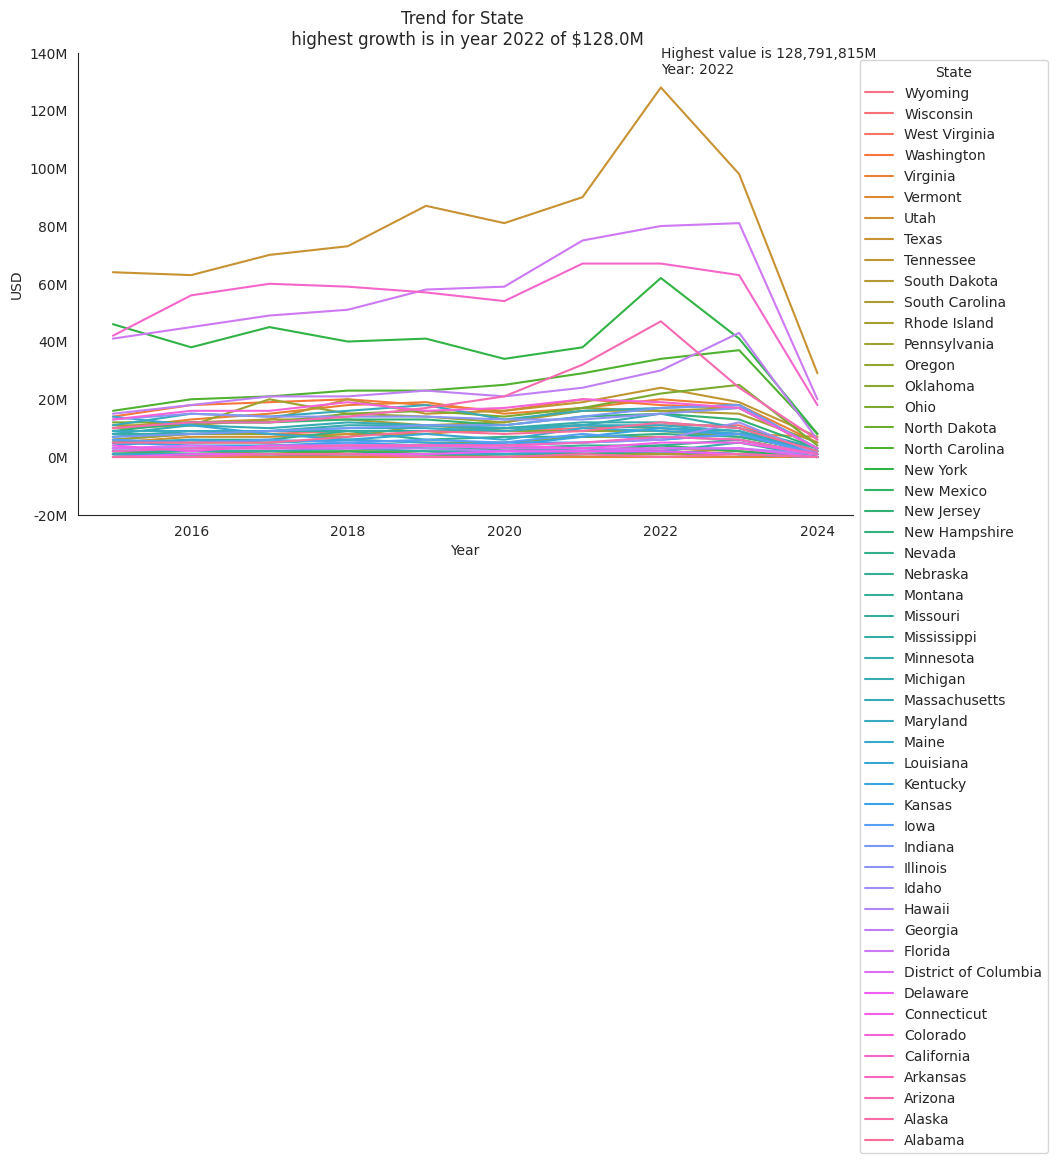

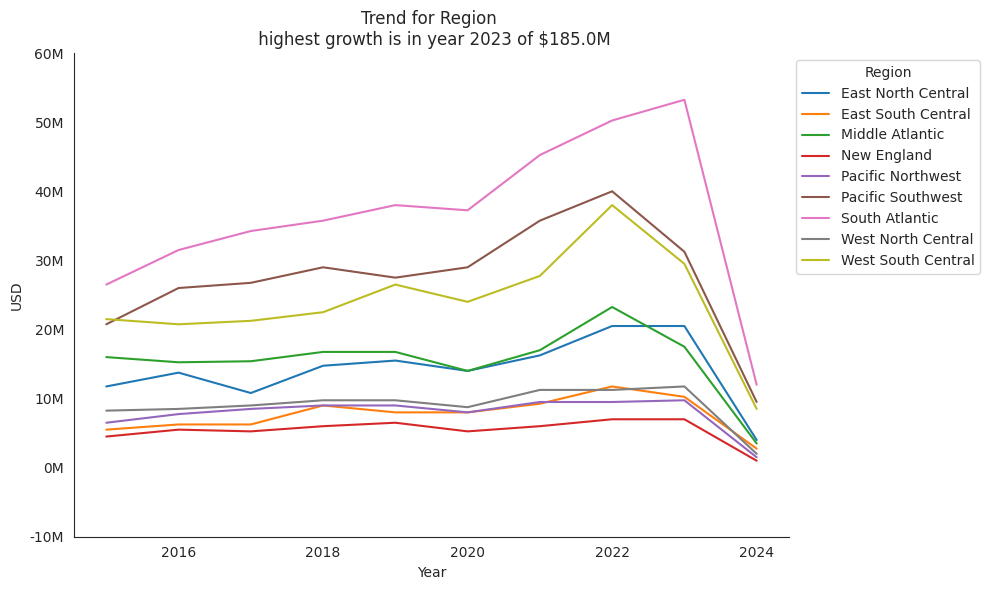

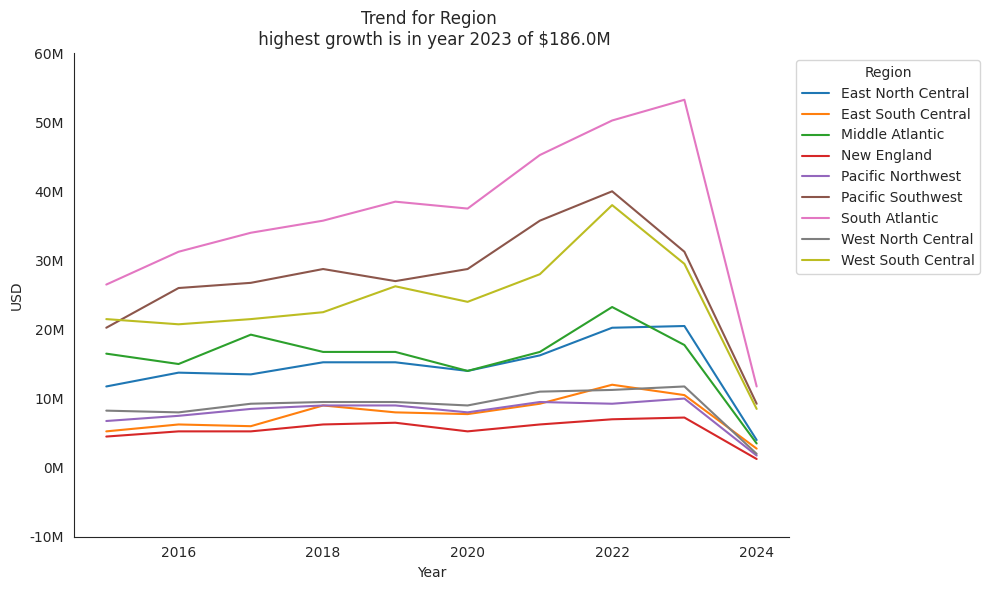

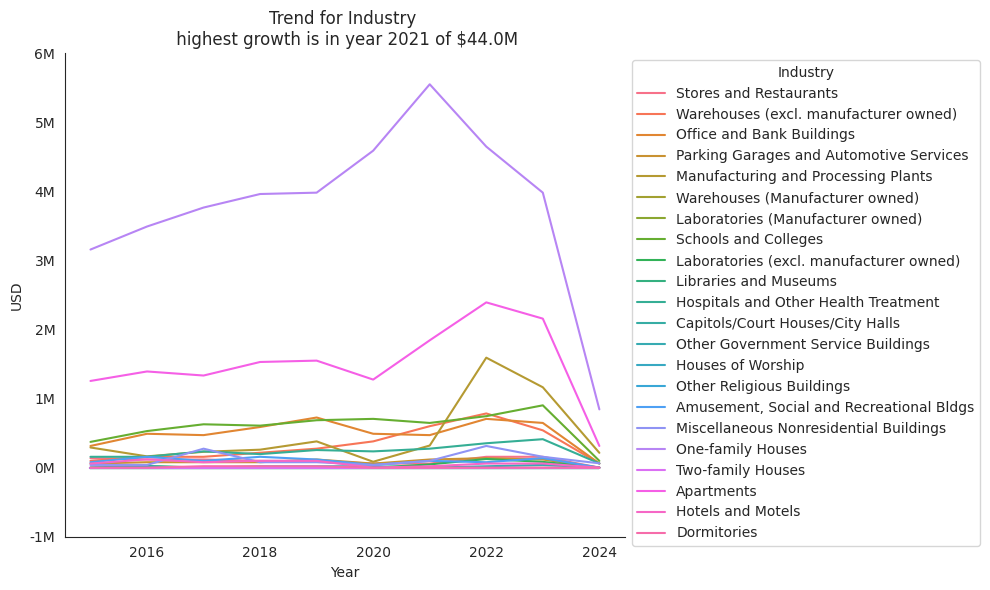

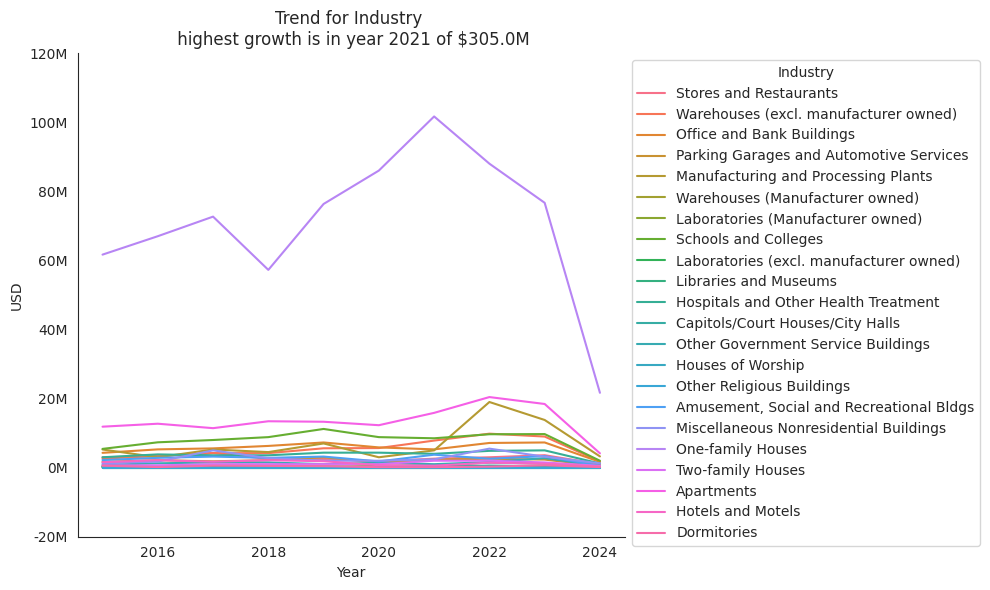

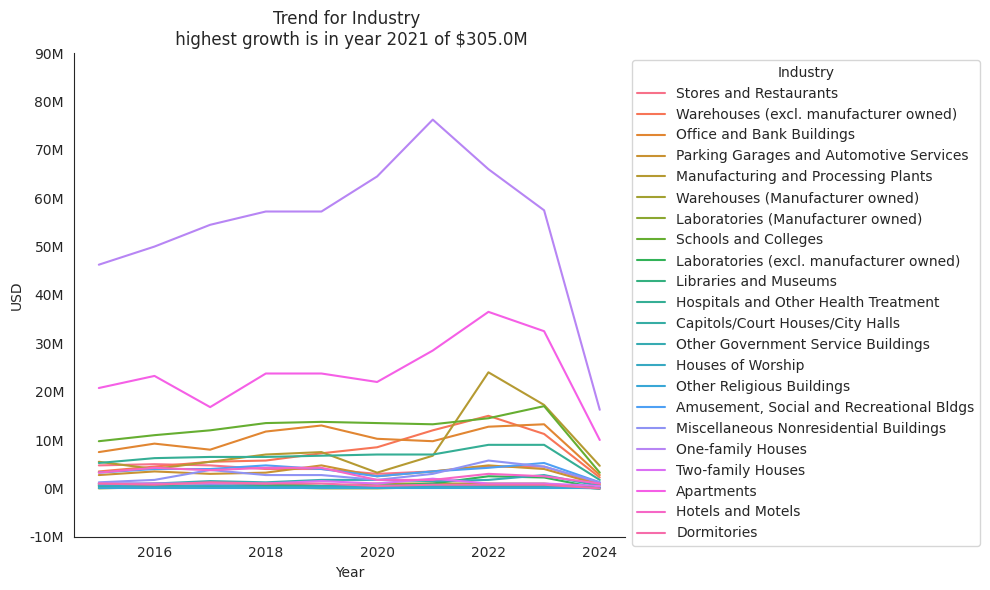

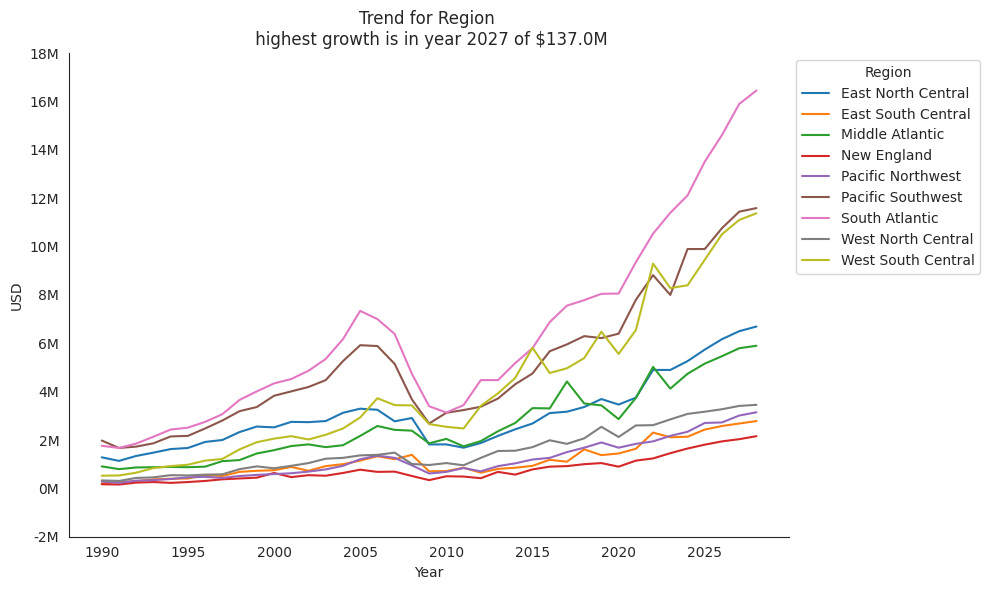

In [ ]:
for df, name in tbl:
    plot_ts(df, 'Year', 'Measure')

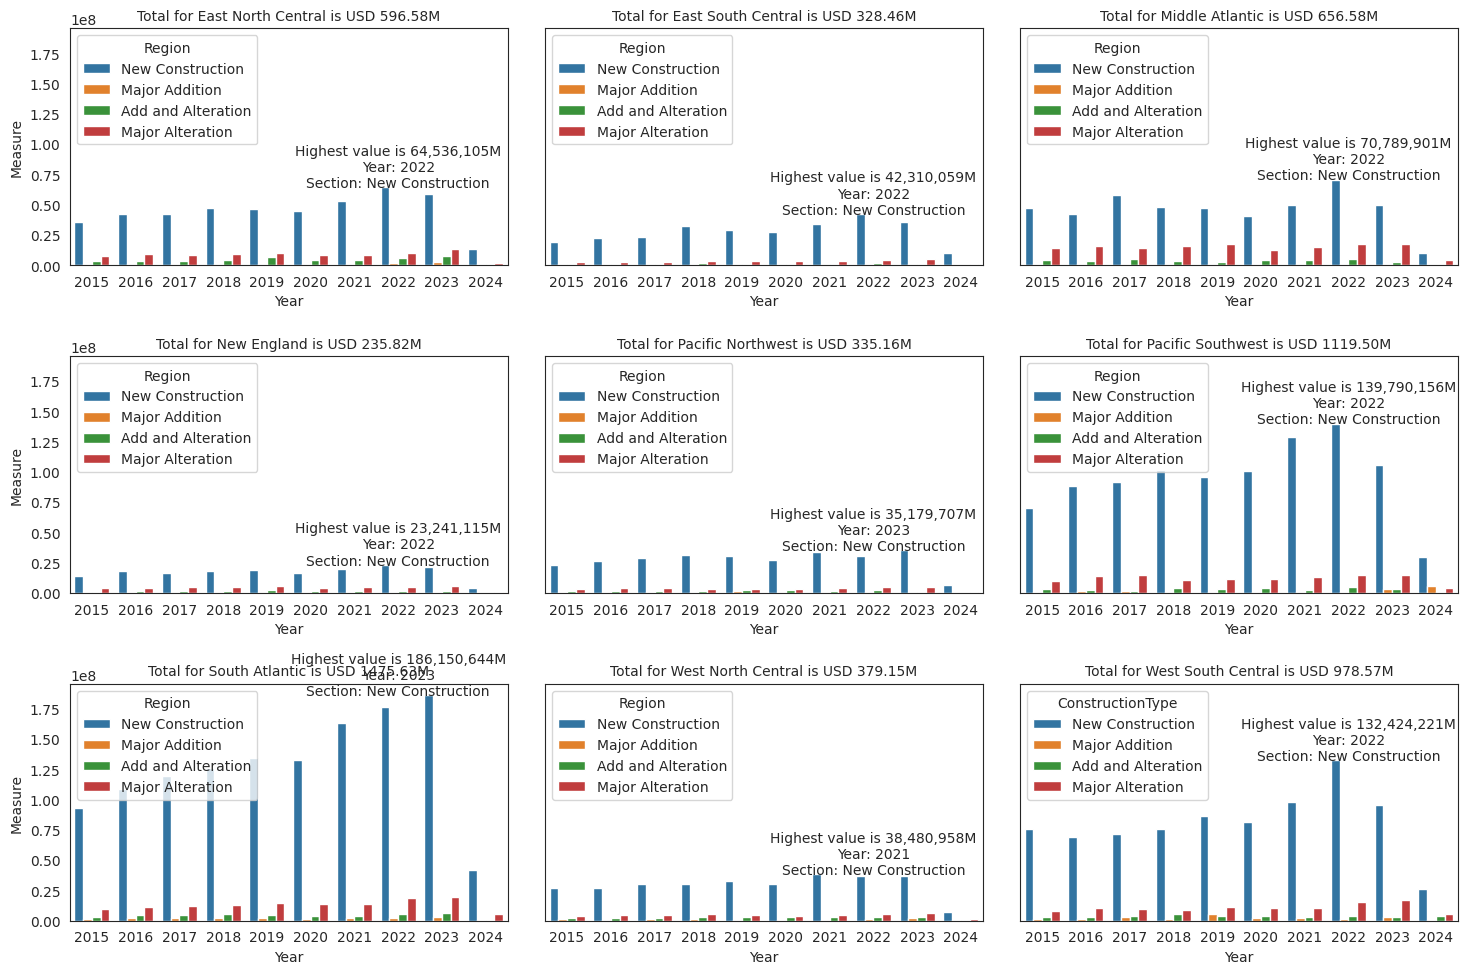

In [ ]:
plot_bar(regionConstType_df,'Region', 'Year','Measure',"ConstructionType")

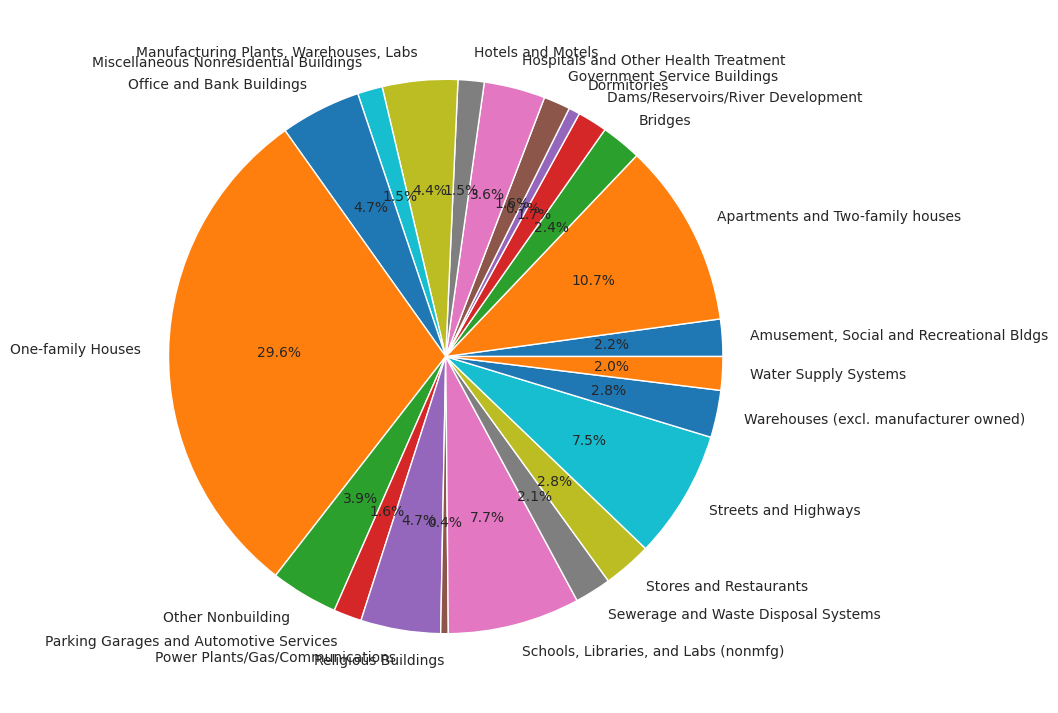

In [ ]:
plt.figure(figsize=(15,9))
plot_pie(regionIndBld_df,"Buildings","Measure")

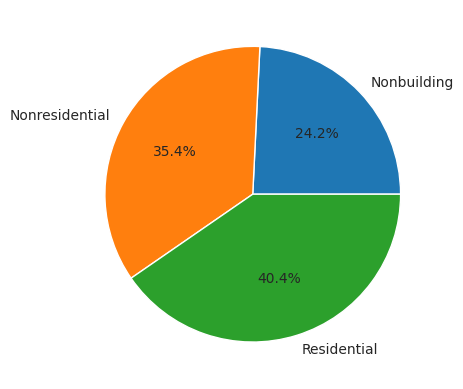

In [ ]:
plot_pie(regionIndBld_df,"IndustrySegment","Measure")

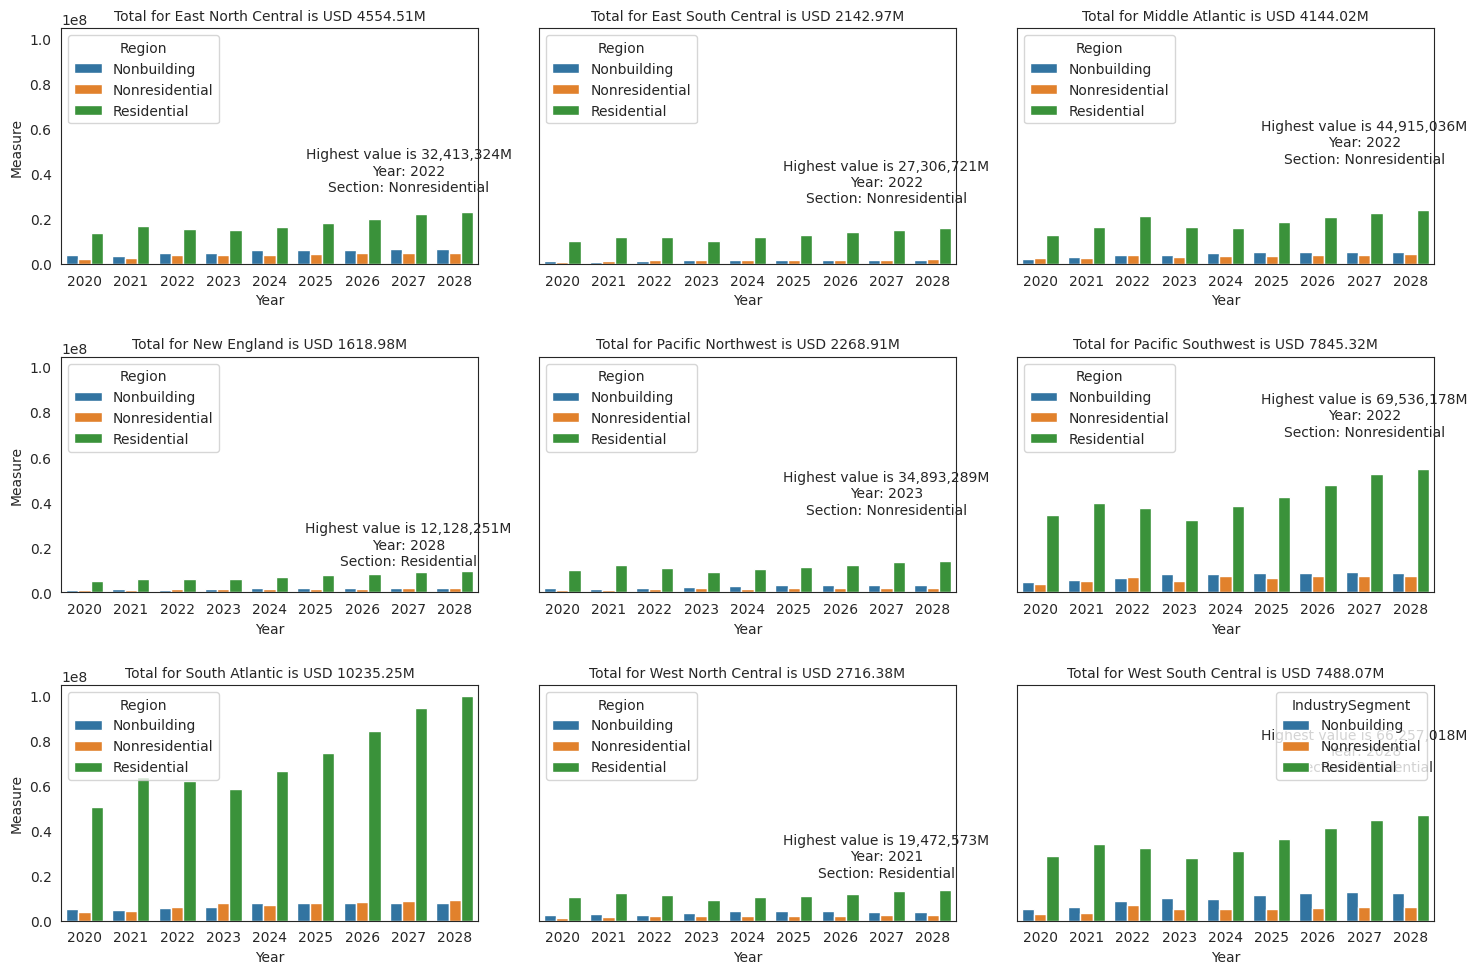

In [ ]:
regionIndBld_df = regionIndBld_df.query("Year > 2019")
plot_bar(regionIndBld_df,'Region', 'Year','Measure',"IndustrySegment")

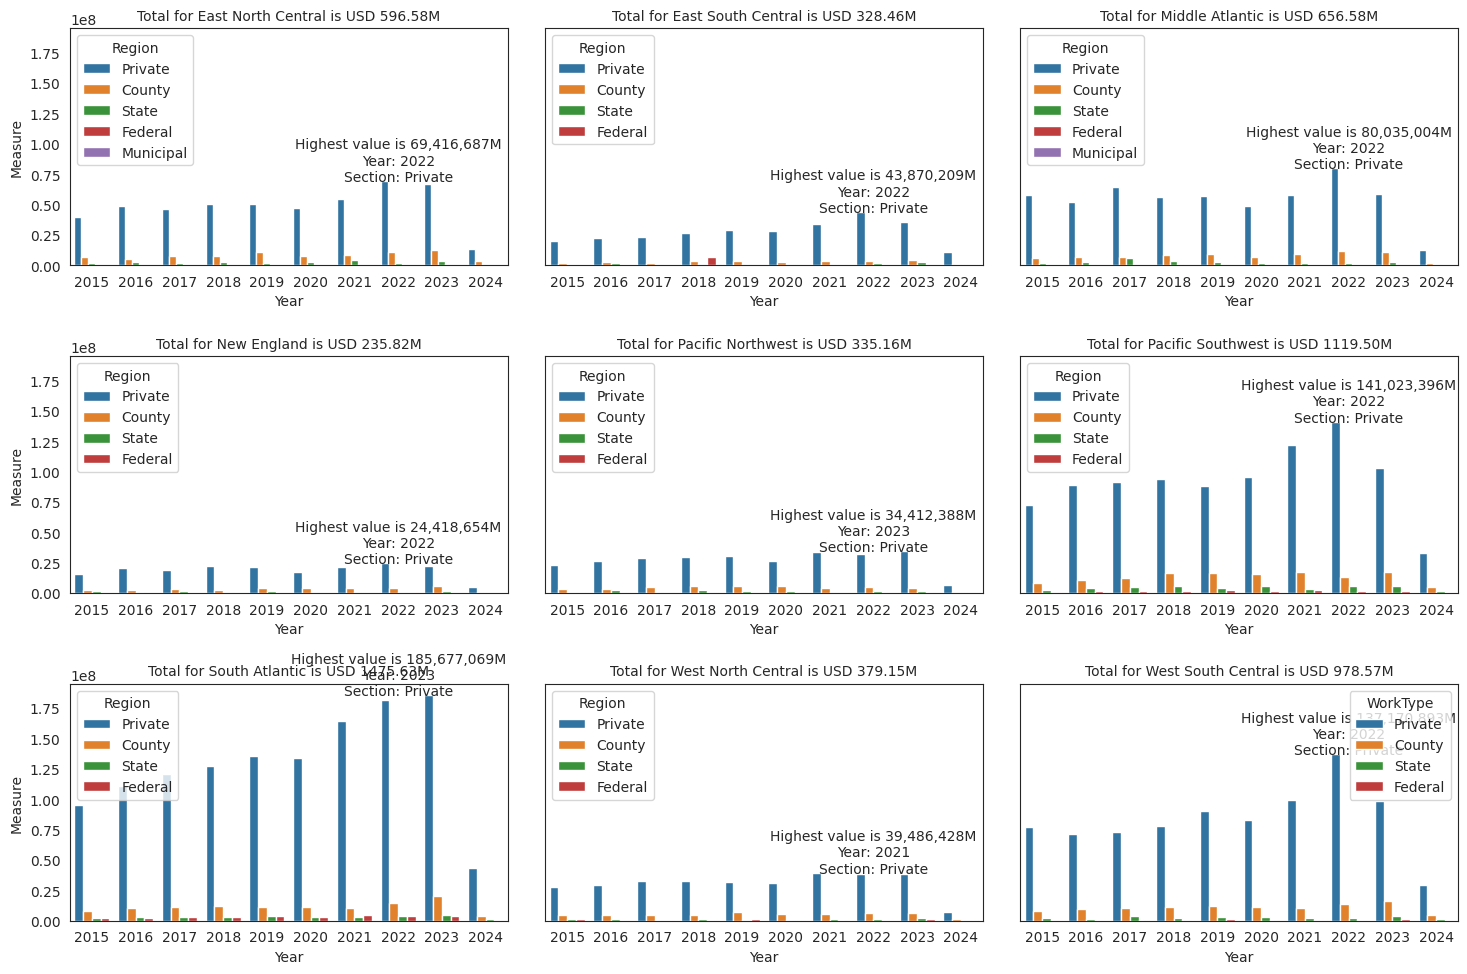

In [ ]:
plot_bar(regionWorktype_df, 'Region', 'Year','Measure',"WorkType")

In [ ]:
data_dir = "/content/drive/MyDrive/AI Course with UC Berkely/capstone/"
regionIndBld_df.to_csv(f"{data_dir}ByRegionIndustryBuildings.csv")

# Economy data

For data, we will perform follwing exploratory analysis

1.   Rename columns to imporve readability
2.   Change columns to appropriate datatypes
3.   Check for null values and drop if there are any null
4.   Check for duplicates and remove them
5.   Visualize data



In [ ]:
# rename column to Dollars from United States [USA] for readability
rename_column(interests_df,"United States [USA]","Dollars")

In [ ]:
check_null(interests_df)

Series Name    3.896104
Series Code    6.493506
Time           6.493506
Time Code      6.493506
Dollars        6.493506
dtype: float64


In [ ]:
interests_df.dropna(inplace=True)

In [ ]:
interests_df.head(2)

,Series Name,Series Code,Time,Time Code,Dollars
0,Broad money growth (annual %),FM.LBL.BMNY.ZG,1990.0,YR1990,2.67796315144365
1,Broad money growth (annual %),FM.LBL.BMNY.ZG,2000.0,YR2000,8.11046448534502


Convert to numeric

In [ ]:
# Replace non-numeric values with NaN
interests_df['Dollars'] = pd.to_numeric(interests_df['Dollars'], errors='coerce')

# Remove rows with NaN values in the 'Dollars' column
interests_df = interests_df.dropna(subset=['Dollars'])

# Convert the 'Dollars' column to integer
interests_df['Dollars'] = interests_df['Dollars'].round(2).astype("float")


<ipython-input-29-286f8579f4c8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interests_df['Dollars'] = interests_df['Dollars'].round(2).astype("float")


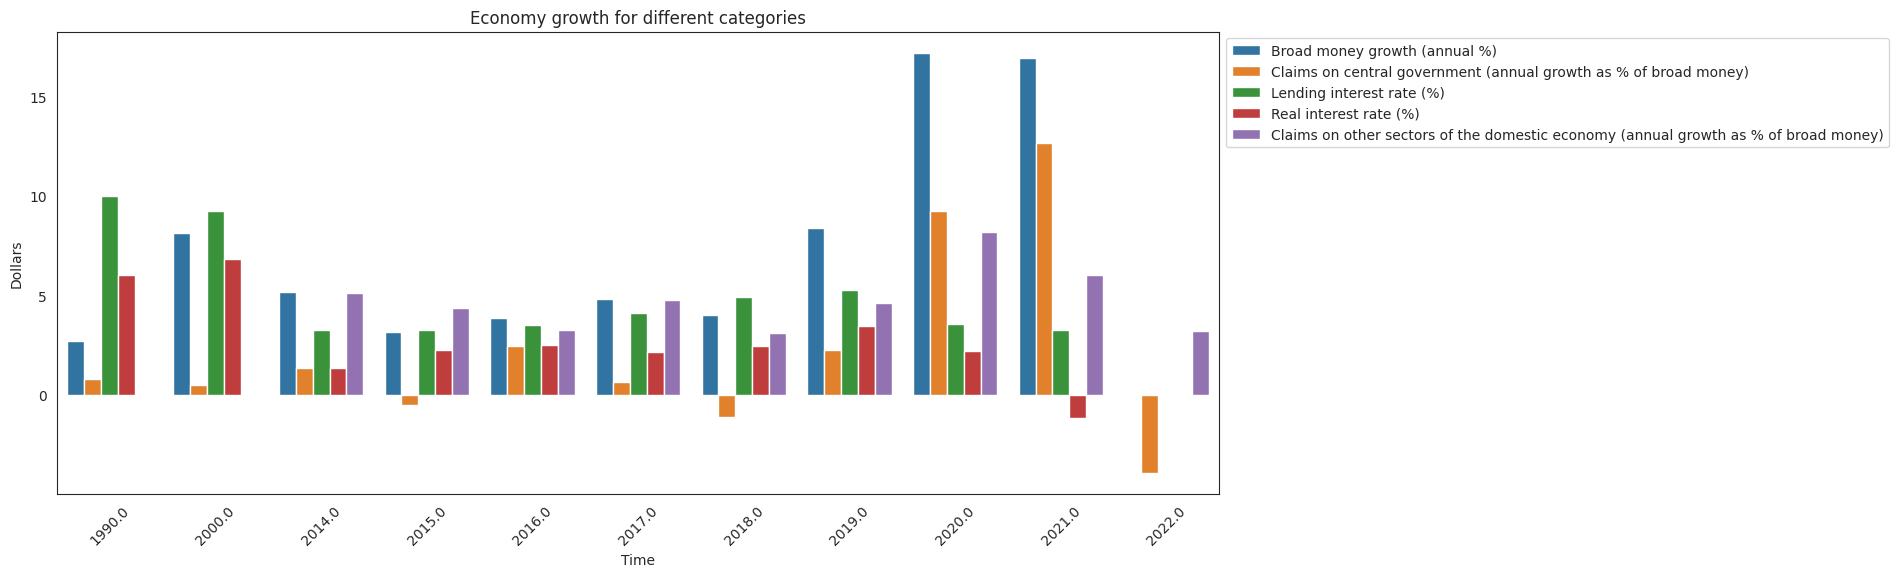

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(data = interests_df,x = "Time",y = "Dollars", hue = 'Series Name')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.title("Economy growth for different categories")
plt.xticks(rotation=45)
plt.show()

Interest rates has down down

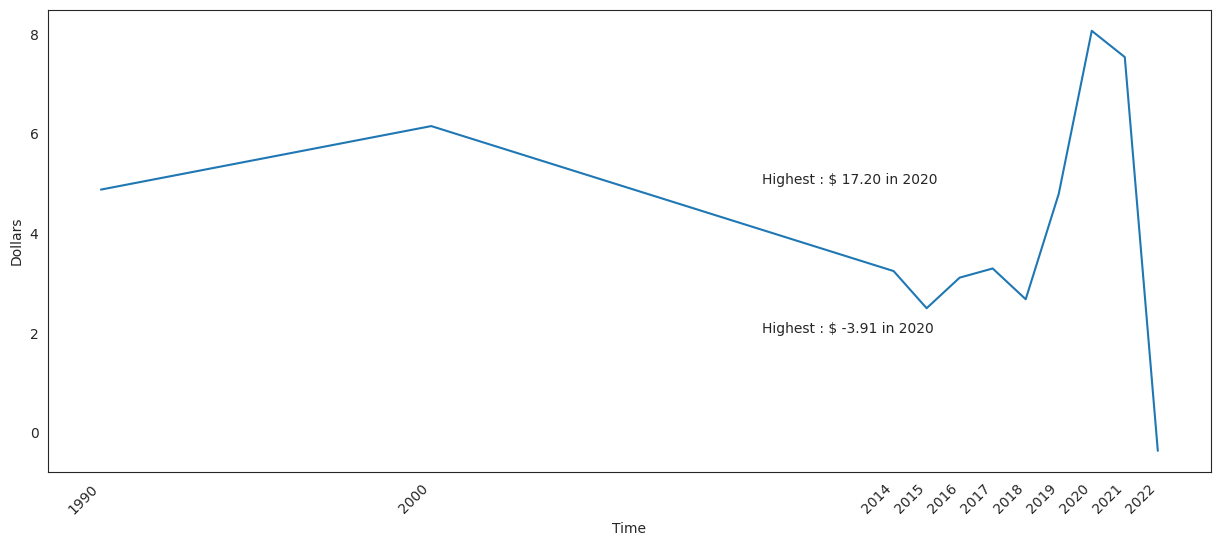

In [ ]:
plot_ts_economy(interests_df,"Time","Dollars")
plt.show()

GDP

In [ ]:
gdp_df.head(2)

,Series Name,Series Code,Time,Time Code,World [WLD],United States [USA]
0,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,1990.0,YR1990,8.06346090938833,5.39795643990325
1,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,2000.0,YR2000,3.43351563418767,3.37685727149929


In [ ]:
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Series Name          14 non-null     object 
 1   Series Code          12 non-null     object 
 2   Time                 12 non-null     float64
 3   Time Code            12 non-null     object 
 4   World [WLD]          12 non-null     object 
 5   United States [USA]  12 non-null     object 
dtypes: float64(1), object(5)
memory usage: 944.0+ bytes


In [ ]:
# Add Datetime column
gdp_df['Date'] = pd.to_datetime(gdp_df['Time'], format="%Y")

In [ ]:
# Rename columns in GSP data
rename_column(gdp_df,"United States [USA]","USA_GDP")

In [ ]:
rename_column(gdp_df,"World [WLD]","World_GDP" )

In [ ]:
# Convert to numeric data
to_numeric(gdp_df, 'World_GDP')
to_numeric(gdp_df, 'USA_GDP')

In [ ]:
# Check for null
check_null(gdp_df)

Series Name    17.647059
Series Code    29.411765
Time           29.411765
Time Code      29.411765
World_GDP      35.294118
USA_GDP        35.294118
Date           29.411765
dtype: float64


In [ ]:
# drop Null
gdp_df.dropna(inplace=True)

In [ ]:
# Check for duplicates
check_duplicates(gdp_df)

No duplicates found.


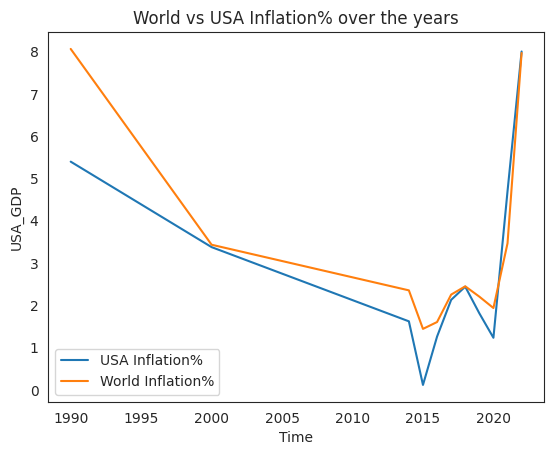

In [ ]:
# Build line plot
sns.lineplot(data = gdp_df, x ="Time" , y= "USA_GDP", label="USA Inflation%")
sns.lineplot(data = gdp_df, x ="Time" , y= "World_GDP",label="World Inflation%")
plt.title("World vs USA Inflation% over the years")
plt.show()

Inflation is at its peak in USA in recent years

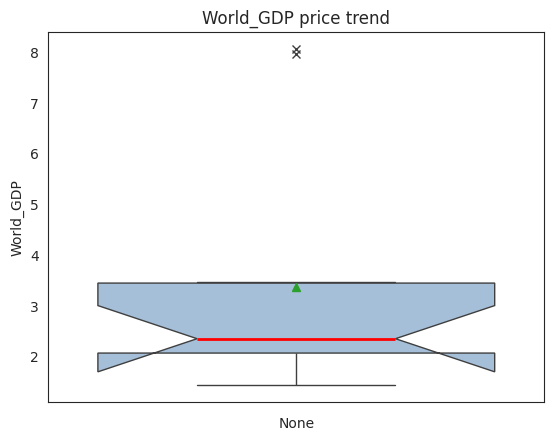

In [ ]:
# Build box plot
plot_box(gdp_df,"World_GDP")

In [ ]:
# find outliers
find_outliers(gdp_df,"World_GDP")

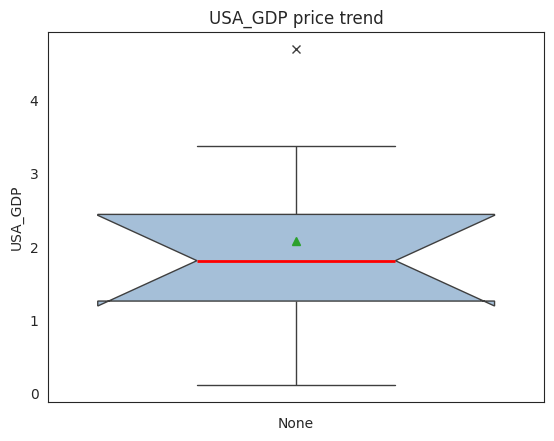

In [ ]:
# draw box plot again to verify above changes
plot_box(gdp_df,"USA_GDP")

Stainless Steel

In [ ]:
stainless_steel.head(2)

,DATE,WPU10170502
0,2010-12-01,100.0
1,2011-01-01,100.7


In [ ]:
# Rename columns
rename_column(stainless_steel,"WPU10170502","Price USD")
rename_column(stainless_steel,"DATE","Date")

In [ ]:
# stainless_steel.reset_index(inplace=True)

In [ ]:
# Convert to date
to_date(stainless_steel,"Date")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       152 non-null    datetime64[ns]
 1   Price USD  152 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.5 KB


In [ ]:
check_null(stainless_steel)

Date         0.0
Price USD    0.0
dtype: float64


In [ ]:
check_duplicates(stainless_steel)

No duplicates found.


In [ ]:
# Add date feature
add_features(stainless_steel,"Date")

,Date,Price USD,Year,Month,Day
0,2010-12-01,100.0,2010,12,12
1,2011-01-01,100.7,2011,1,1


Text(0.5, 1.0, 'Stainless Steel Price Trend')

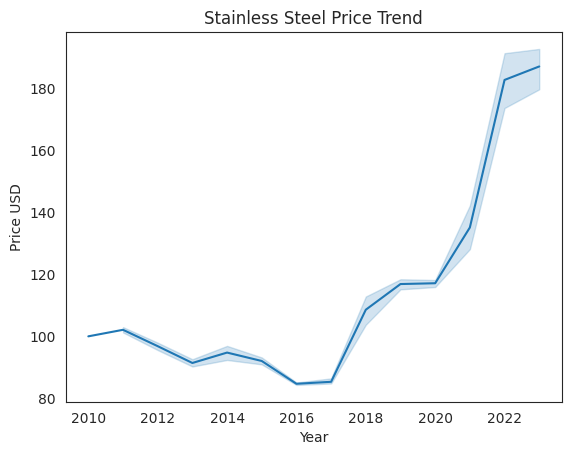

In [ ]:
sns.lineplot(data = stainless_steel,x ="Year", y = "Price USD" )
plt.title("Stainless Steel Price Trend")

<Axes: xlabel='Month', ylabel='Price USD'>

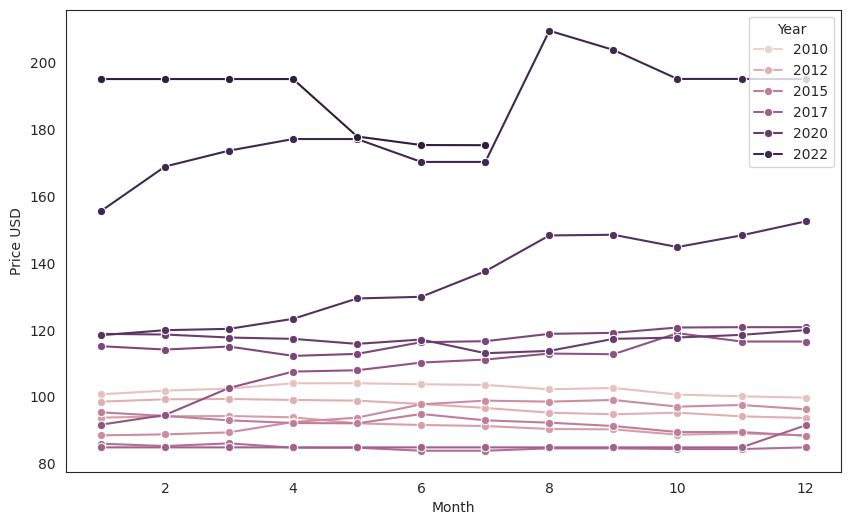

In [ ]:
# Set 'Date' column as the index
# stainless_steel.set_index('Date', inplace=True)

# Plot monthly prices within each year
plt.figure(figsize=(10, 6))
sns.lineplot(data=stainless_steel, x="Month", y='Price USD', hue="Year", marker='o')


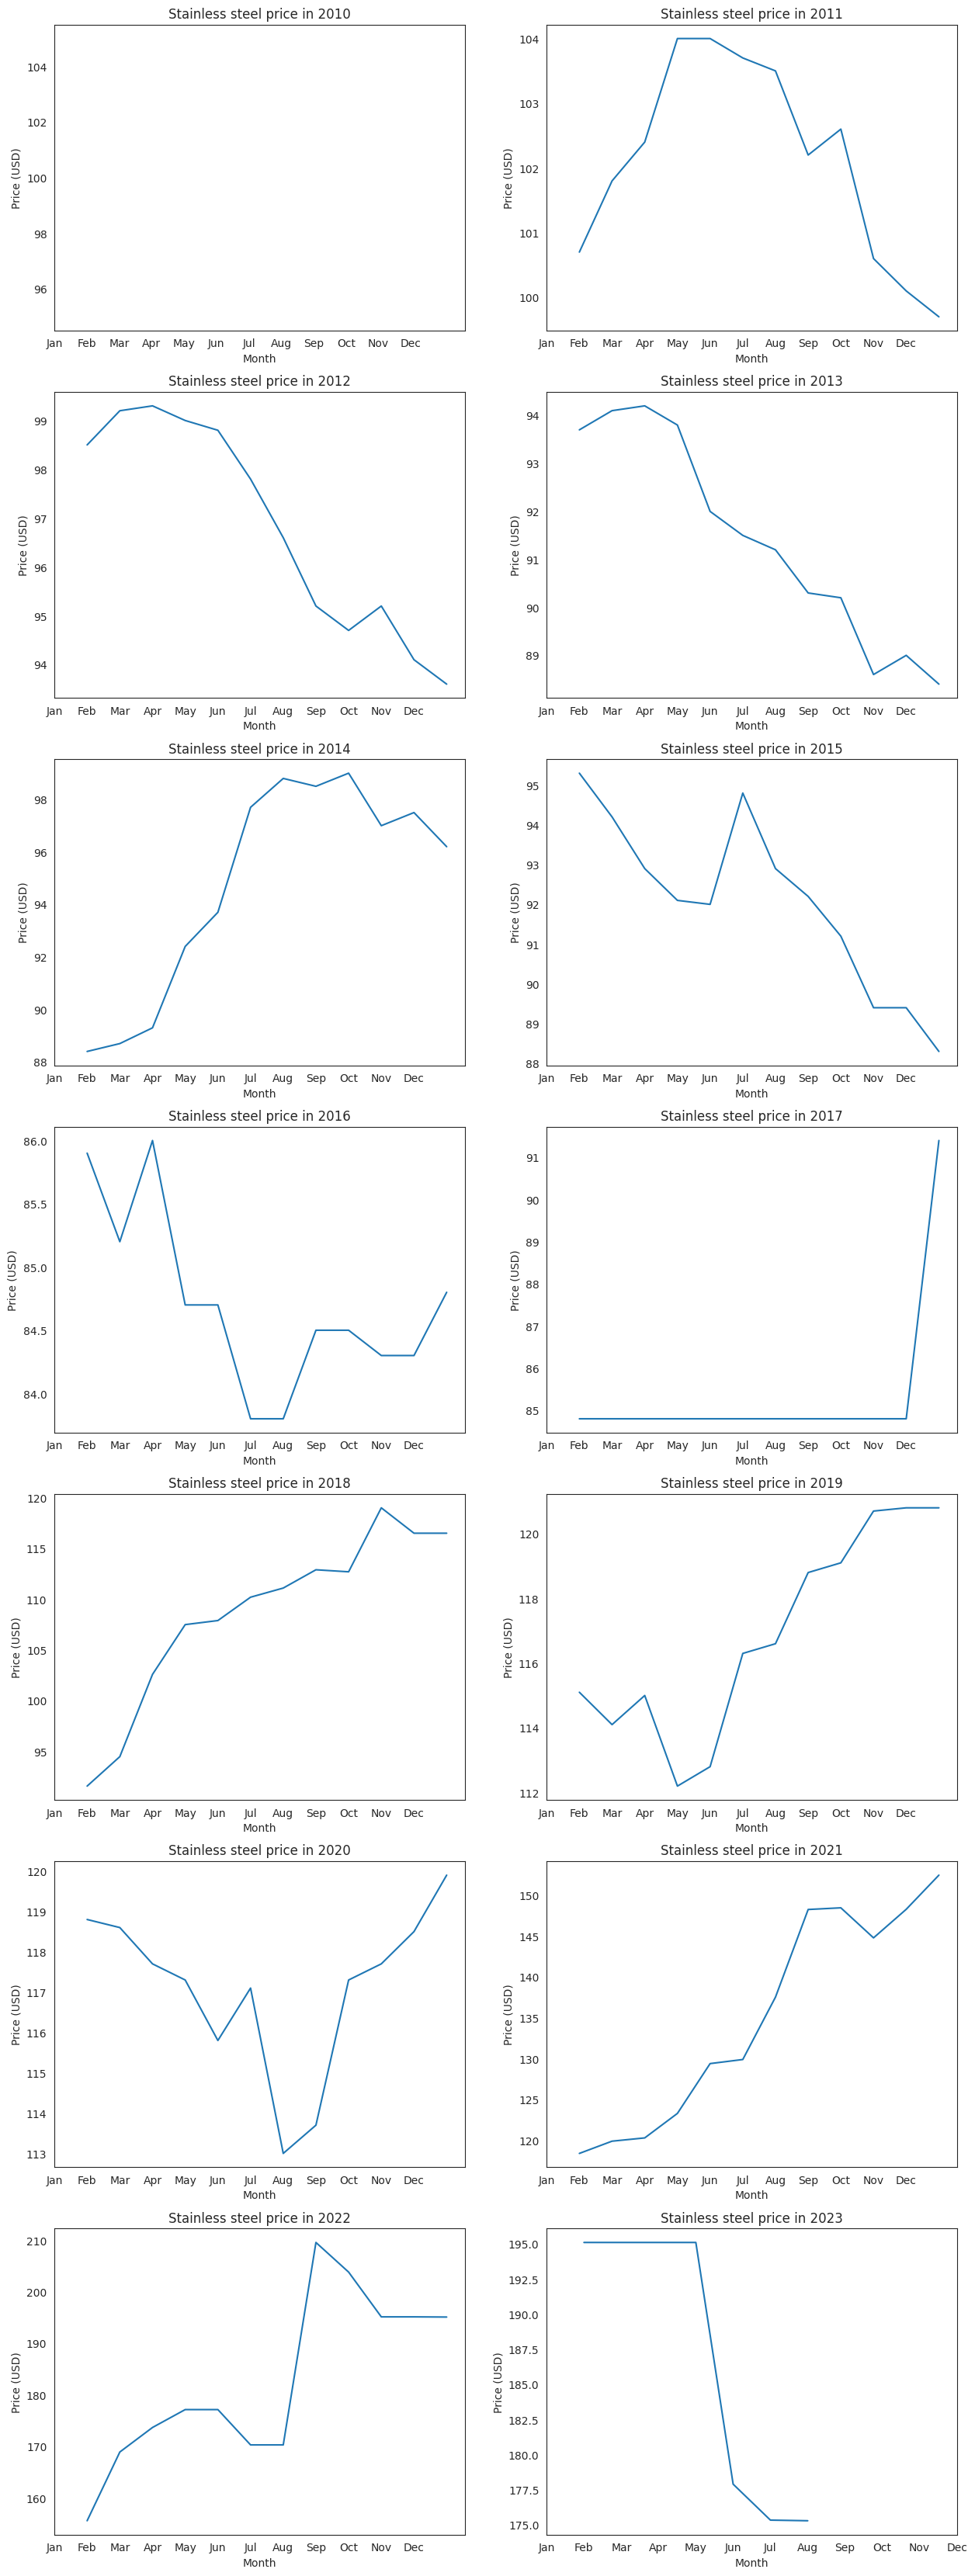

In [ ]:
years = stainless_steel["Year"].unique()
num_years = len(years)
num_subplots = min(num_years, 2)  # Define the maximum number of subplots per row
nrows = (num_years - 1) // num_subplots + 1
ncols = min(num_years, num_subplots)

fig, axes = plt.subplots(nrows, ncols, figsize=(15,6*nrows))

for i, yr in enumerate(years):
  # Calculate the row and column index for the current subplot
  row = i // num_subplots
  col = i % num_subplots
  yr_data = stainless_steel[stainless_steel['Year'] == yr]
  sns.lineplot(data = yr_data , x ="Month", y="Price USD", ax =axes[row, col])
  ax=axes[row, col].set_title(f"Stainless steel price in {yr}")
  ax=axes[row, col].set_xlabel("Month")
  ax=axes[row, col].set_ylabel("Price (USD)")

  # change axes to Jan, feb.. from 1,2..
  month_names = [calendar.month_abbr[i] for i in range(1,13)]
  axes[row, col].set_xticks(range(12))  # Set tick positions from 0 to 11
  axes[row, col].set_xticklabels(month_names)

  # remove unsed subplot
  for i in range(num_years, nrows * ncols):
    row = i // num_subplots
    col = i % num_subplots
    fig.delaxes(axes[row,col])
plt.show()


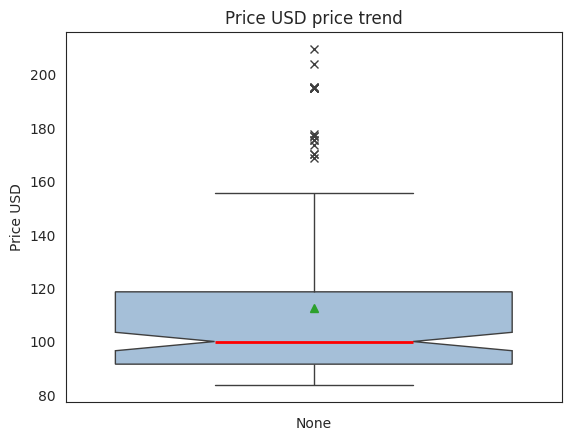

In [ ]:
# Check for outliers
plot_box(stainless_steel,"Price USD")

We have few outliers so we will remove them

In [ ]:
find_outliers(stainless_steel, "Price USD")

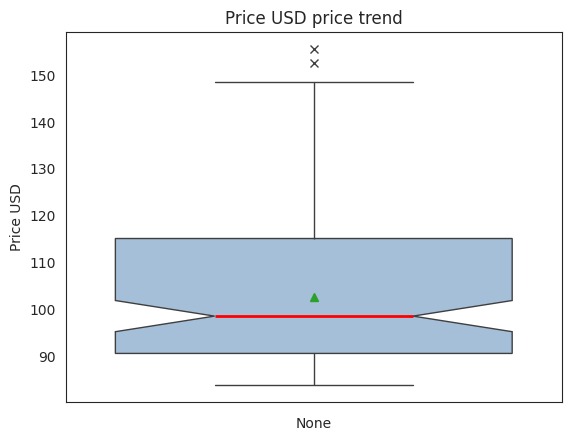

In [ ]:
plot_box(stainless_steel, "Price USD")

ACF results are: [1.         0.95137173 0.90181078 0.85510313 0.80795506 0.75131039
 0.69215954 0.64716017 0.61212726 0.57591154 0.54885003 0.52498549
 0.50130321 0.47957507 0.45755753 0.43654927 0.41497845 0.39438001
 0.37957354 0.36520895 0.34551612 0.32738151] 

PACF results are: [ 1.          0.9585249  -0.04056879  0.00576273 -0.03616173 -0.15137952
 -0.06960133  0.13919949  0.0992469  -0.02202031  0.10880052 -0.02456554
 -0.06394286  0.02395251 -0.01493764 -0.01101286  0.01451576  0.02453289
  0.05761321  0.00959895 -0.08944536 -0.00951737], 



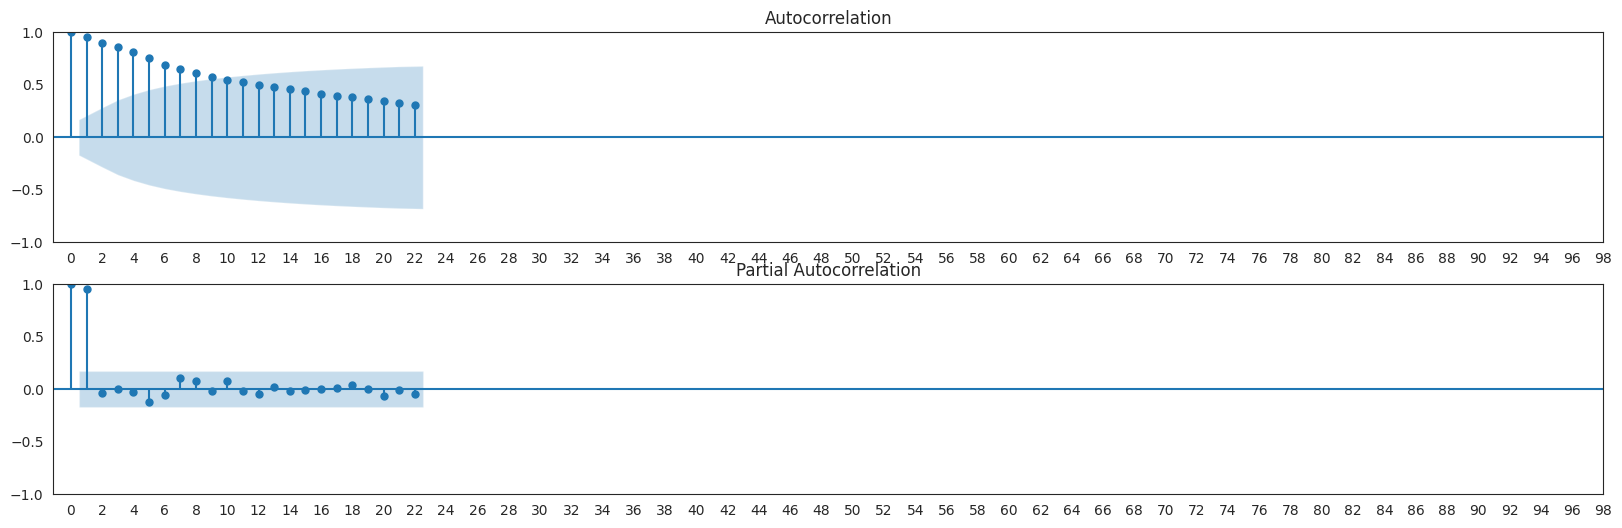

In [ ]:
plot_acf_pacf(stainless_steel, "Price USD")

Based on the provided ACF and PACF results, we can determine the values of `p`, `d`, `q`, `P`, `D`, and `Q` for the SARIMA model:

**Interpretation:**
- **p (non-seasonal AR order):** From the PACF, there is a significant spike at lag 1, suggesting an AR order of 1.
- **d (non-seasonal differencing order):** The presence of a significant spike at lag 1 in the ACF suggests that differencing may not be required (d=0).
- **q (non-seasonal MA order):** From the ACF, there are significant spikes at multiple lags, suggesting a possible MA order of 1 or 2.
- **P (seasonal AR order):** From the seasonal PACF, there are significant spikes at lag 1 and a few higher seasonal lags, suggesting a seasonal AR order of 1.
- **D (seasonal differencing order):** The seasonal differencing order could be 1 based on the significant spikes at lag 1 in the seasonal ACF.
- **Q (seasonal MA order):** From the seasonal ACF, there are significant spikes at multiple seasonal lags, suggesting a possible seasonal MA order of 1 or 2.

Based on these observations, a possible SARIMA model could be: SARIMA(1,0,1)(1,1,1) or SARIMA(1,0,2)(1,1,2), depending on additional analysis and model selection criteria.

## Combine Economy data and generate new feature "Economy Status"

In [ ]:
# Convert 'Date' to datetime and set as index
stainless_steel['Date'] = pd.to_datetime(stainless_steel['Date'])
stainless_steel.set_index('Date', inplace=True)

gdp_df['Date'] = pd.to_datetime(gdp_df['Date'])
gdp_df.set_index('Date', inplace=True)

In [ ]:
# For interests_df, as 'Time' doesn't represent the exact date, we'll set it to January 1st of the corresponding year
interests_df['Date'] = pd.to_datetime('01-01-' + interests_df['Time'].astype(int).astype(str))
interests_df.set_index('Date', inplace=True)

# Concatenate dataframes
economy_df = pd.concat([stainless_steel, gdp_df, interests_df])

# remove unused columns
economy_df.drop("Series Code", axis=1)

economy_df.head(2)

,Price USD,Year,Month,Day,Series Name,Series Code,Time,Time Code,World_GDP,USA_GDP,Dollars
Date,,,,,,,,,,,
2010-12-01,100.0,2010.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01,100.7,2011.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rename_column(economy_df,"Dollars","Interest Rate")
rename_column(economy_df,"Price USD","Stainless Steel Price USD")

In [ ]:
economy_df.drop(['Time Code','Series Code','Series Name'],axis =1, inplace = True)

In [ ]:
# Sort date in ascending value
economy_df.sort_values(by="Date", ascending=True, inplace= True)

In [ ]:
economy_df.sample(3)

,Stainless Steel Price USD,Year,Month,Day,Time,World_GDP,USA_GDP,Interest Rate
Date,,,,,,,,
2018-05-01,107.9,2018.0,5.0,5.0,NaN,NaN,NaN,NaN
2013-08-01,90.3,2013.0,8.0,8.0,NaN,NaN,NaN,NaN
2016-12-01,84.8,2016.0,12.0,12.0,NaN,NaN,NaN,NaN


In [ ]:
fill_na_mean(economy_df,"World_GDP")
fill_na_mean(economy_df,"USA_GDP")
fill_na_mean(economy_df,"Interest Rate")
fill_na_mean(economy_df,"Stainless Steel Price USD")

In [ ]:
# drop null values
columns_to_check = ['Stainless Steel Price USD', 'Year', 'Month', 'Day']
economy_df.dropna(subset=columns_to_check, inplace=True)

In [ ]:
economy_df.reset_index(inplace=True)

In [ ]:
# Print the DataFrame info to verify the changes
print(economy_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       134 non-null    datetime64[ns]
 1   Stainless Steel Price USD  134 non-null    float64       
 2   Year                       134 non-null    float64       
 3   Month                      134 non-null    float64       
 4   Day                        134 non-null    float64       
 5   Time                       0 non-null      float64       
 6   World_GDP                  134 non-null    float64       
 7   USA_GDP                    134 non-null    float64       
 8   Interest Rate              134 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 9.5 KB
None


In [ ]:
# Assuming df is your DataFrame containing the provided data
economy_df.drop_duplicates(subset='Date', keep='first', inplace=True)

In [ ]:
economy_df.head(3)

,Date,Stainless Steel Price USD,Year,Month,Day,Time,World_GDP,USA_GDP,Interest Rate
0,2010-12-01,100.0,2010.0,12.0,12.0,NaN,2.35022,2.077293,4.3912
1,2011-01-01,100.7,2011.0,1.0,1.0,NaN,2.35022,2.077293,4.3912
2,2011-02-01,101.8,2011.0,2.0,2.0,NaN,2.35022,2.077293,4.3912


In [ ]:
economy_df.to_csv(f"{data_dir}/ecs.csv")

In [ ]:
def determine_economy_status(df):
    status = []
    dates = df.index
    for i in range(len(dates) - 1):
        current_date = dates[i + 1]  # Get the next date
        # print("Current date:", current_date)  # Add this line for debugging
        previous_date = dates[i]  # Get the current date

        current_row = df.loc[current_date]
        previous_row = df.loc[previous_date]

        if current_row["Stainless Steel Price USD"] > previous_row["Stainless Steel Price USD"]:
            status.append("Bullish")
        elif current_row["Stainless Steel Price USD"] < previous_row["Stainless Steel Price USD"]:
            status.append("Bearish")
        else:
            status.append("Neutral")

    # Check if the last row is already processed
    if len(status) < len(dates):
        status.append(np.nan)

    return status


In [ ]:
# def determine_economy_status(df):
#     status = []
#     dates = df.index
#     for i in range(len(dates) - 1):
#         current_date = dates[i + 1]  # Get the next date
#         print("Current date:", current_date)  # Add this line for debugging
#         previous_date = dates[i]  # Get the current date

#         current_row = df.loc[current_date]
#         previous_row = df.loc[previous_date]

#         if current_row["Stainless Steel Price USD"] > previous_row["Stainless Steel Price USD"] and \
#             current_row["World_GDP"] > previous_row["World_GDP"] and \
#             current_row["USA_GDP"] > previous_row["USA_GDP"] and \
#             current_row["Interest Rate"] > previous_row["Interest Rate"]:
#             status.append("Bullish")
#         elif current_row["Stainless Steel Price USD"] < previous_row["Stainless Steel Price USD"] and \
#             current_row["World_GDP"] < previous_row["World_GDP"] and \
#             current_row["USA_GDP"] < previous_row["USA_GDP"] and \
#             current_row["Interest Rate"] < previous_row["Interest Rate"]:
#             status.append("Bearish")
#         else:
#             status.append("Neutral")

#     # Check if the last row is already processed
#     if len(status) < len(dates):
#         status.append(np.nan)

#     return status


In [ ]:
# Apply function to calculate Economy Status
economy_df['Economy_Status'] = determine_economy_status(economy_df)

In [ ]:
economy_df['Economy_Status'].unique()

array(['Bullish', 'Neutral', 'Bearish', nan], dtype=object)

In [ ]:
economy_df.dropna(subset="Economy_Status", inplace= True)

In [ ]:
economy_df.drop(columns=['World_GDP','USA_GDP','Interest Rate'], inplace = True)

In [ ]:
economy_df.drop(columns=['Time'], inplace = True)

In [ ]:
economy_df.head(3)

,Date,Stainless Steel Price USD,Year,Month,Day,Economy_Status
0,2010-12-01,100.0,2010.0,12.0,12.0,Bullish
1,2011-01-01,100.7,2011.0,1.0,1.0,Bullish
2,2011-02-01,101.8,2011.0,2.0,2.0,Bullish


### Save Economy data to a csv file

In [ ]:
# Save data to csv file
data_dir = "/content/drive/MyDrive/AI Course with UC Berkely/capstone/"
stainless_steel.to_csv(f"{data_dir}cleaned_stainlessSteel.csv")
gdp_df.to_csv(f"{data_dir}cleaned_gdp.csv")
economy_df.to_csv(f"{data_dir}economy_data.csv")

# Finance data

In [ ]:
# financial data
# company_financials_df = pd.read_csv(f"{data_dir}/ZWS.csv")

In [ ]:
zws = pd.read_csv("/content/drive/MyDrive/AI Course with UC Berkely/capstone/ZWS.csv")
zws.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-29,28.780001,29.230000,28.650000,29.000000,27.952473,681100
1,2019-04-30,29.030001,29.030001,28.350000,28.600000,27.566919,561600
2,2019-05-01,28.809999,28.990000,28.459999,28.500000,27.470535,539600
3,2019-05-02,28.309999,28.639999,28.110001,28.620001,27.586203,582800
4,2019-05-03,28.879999,29.260000,28.709999,29.049999,28.000660,433300


In [ ]:
# view the data types and non-null values in the dataset
zws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


Data Cleaning
1.   Check for missing values
2.   Check for duplicates
3.   Convert data types
4.   Rename columns for better readability
5.   Handle Outliers
6.   Add new features
7.   Standardize data

In [ ]:
check_null(zws)

Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64


In [ ]:
check_duplicates(zws)

No duplicates found.


In [ ]:
to_date(zws, "Date")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1259 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


When the median is closer to the bottom of the box, and if the whisker is shorter on the lower end of the box, then the distribution is positively skewed (skewed right).
Distribution is not symmetric as whiskers are not of same length on both side of box and median is not in center.


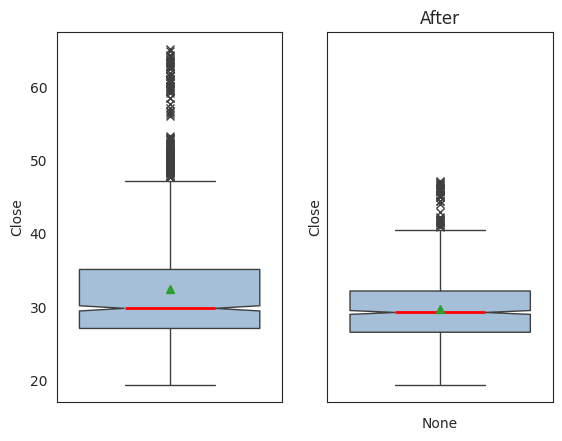

In [ ]:
from subprocess import check_output
fig, ax = plt.subplots(1,2, sharey=True)
plot_box(zws, "Close", ax=ax[0])
plt.title("Before")

find_outliers(zws, "Close")
plot_box(zws, "Close", ax = ax[1])
plt.title("After")

plt.show()

After remoing outliers, we can see mean has changed

Visualize Finance Data Now

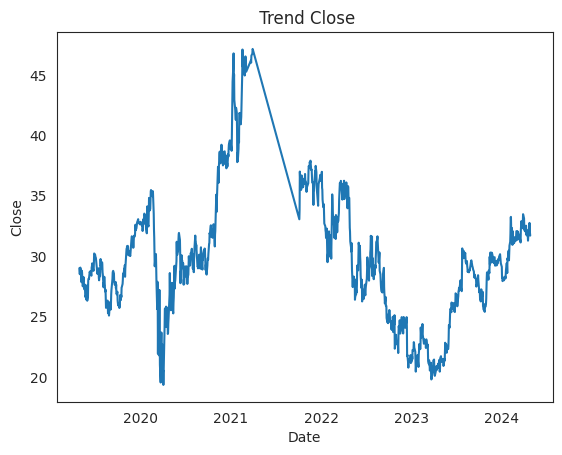

In [ ]:
plot_ts_stocks(zws,"Date","Close")

We can see that closing price increased in 2021 but droped to same level in 2023 to 2020.

In [ ]:
add_features(zws, "Date")

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2019-04-29,28.780001,29.230000,28.65,29.0,27.952473,681100,2019,4,4
1,2019-04-30,29.030001,29.030001,28.35,28.6,27.566919,561600,2019,4,4


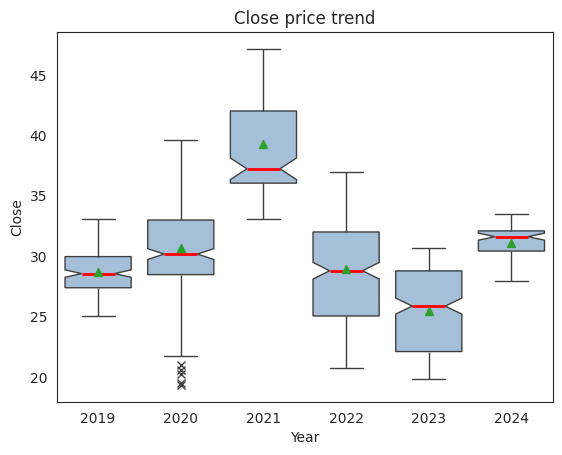

In [ ]:
plot_box(zws,y= "Close", X= 'Year')

We can see that proice increase in 2020 and 2021 but dropepd to almost same level in 2019 and was lowest in 2023. In 2024, it has been higher after 2021

## We can create a heatmap to visualize the correlation between stock prices


In [ ]:
zws.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2019-04-29,28.780001,29.230000,28.65,29.0,27.952473,681100,2019,4,4
1,2019-04-30,29.030001,29.030001,28.35,28.6,27.566919,561600,2019,4,4


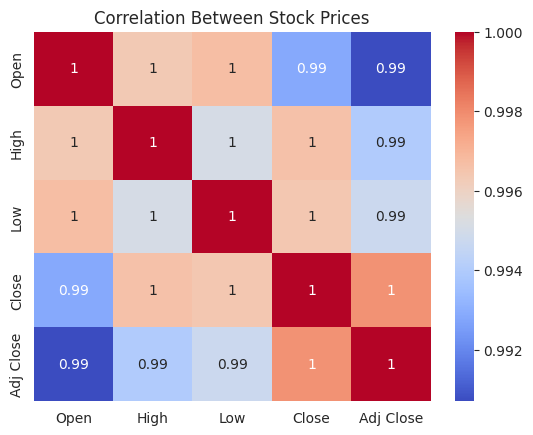

In [ ]:
corr = zws[['Open','High','Low','Close','Adj Close']].corr()
sns.heatmap(corr, annot=True, cmap = 'coolwarm')
plt.title('Correlation Between Stock Prices')
plt.show()

We can see that
- Opening and Closing price has a strong +ve correlation. Low and High has weak correlation

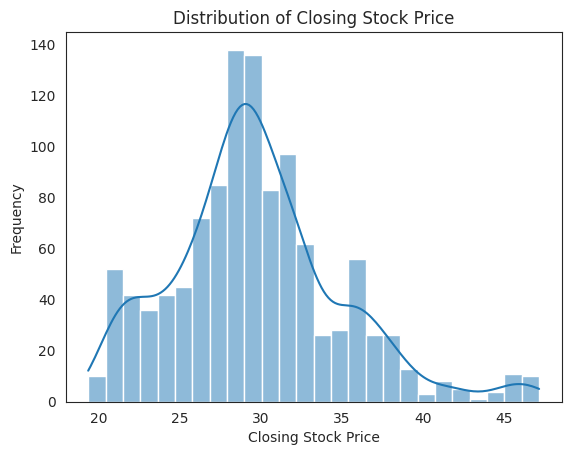

In [ ]:
sns.histplot(zws['Close'], kde=True)
plt.title('Distribution of Closing Stock Price')
plt.xlabel("Closing Stock Price")
plt.ylabel("Frequency")
plt.show()

We can use a combination chart to visualize the stock prices with the volume traded.

In [ ]:
zws.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2019-04-29,28.780001,29.230000,28.65,29.0,27.952473,681100,2019,4,4
1,2019-04-30,29.030001,29.030001,28.35,28.6,27.566919,561600,2019,4,4


In [ ]:
years = zws['Year'].unique().tolist()
years

[2019, 2020, 2021, 2022, 2023, 2024]

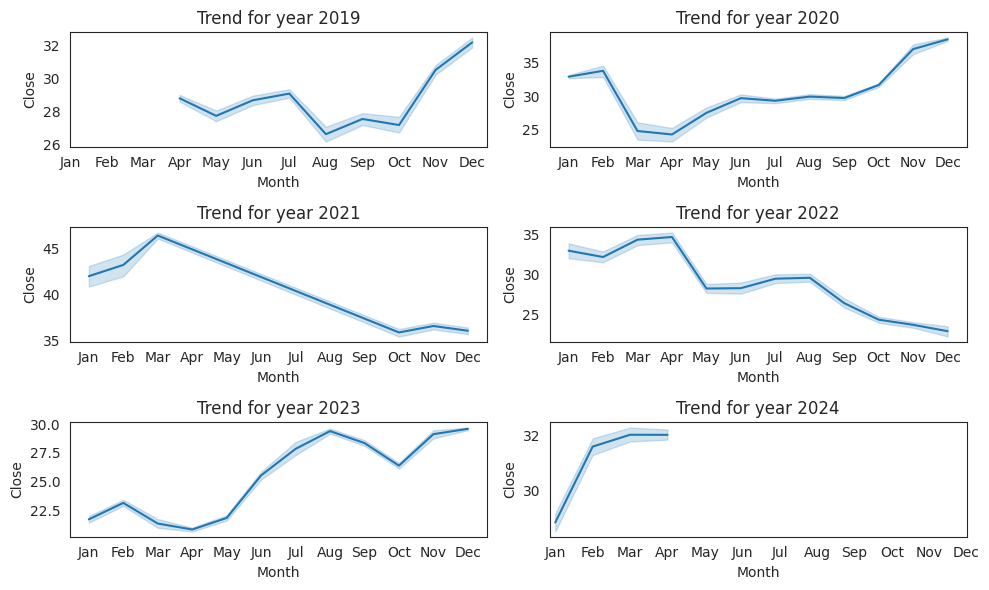

In [ ]:
month_names = [calendar.month_abbr[i] for i in range(1,13)]
ncols = 2  # Set the number of columns for subplots
nrows = math.ceil(len(years) / ncols)  # Calculate the number of rows based on the number of years
fig, axes = plt.subplots(nrows, ncols, figsize=(10,6))
for i, year in enumerate(years):
  row = i // ncols
  col = i % ncols
  sns.lineplot(data = zws[zws['Year'] == year],x = 'Month', y='Close', ax = axes[row,col])
  axes[row,col].set_title(f"Trend for year {year}")
  axes[row,col].set_xticks(range(1,13))
  axes[row,col].set_xticklabels(month_names)

# Remove unused subplots
for i in range(len(years), nrows * ncols):
  row = i // ncols
  col = i % ncols
  fig.delaxes(axes[row,col])

plt.tight_layout()
plt.show()



## Find monthly return

In [ ]:
# line calculates the percentage change in the 'Close' price for each individual data point relative to the previous data point within the same 'Year' and 'Month' group.
zws['Monthly_Return'] = zws.groupby(['Year','Month'])['Close'].transform(lambda x: x.pct_change() * 100)
zws.dropna(subset = 'Monthly_Return' , inplace = True)

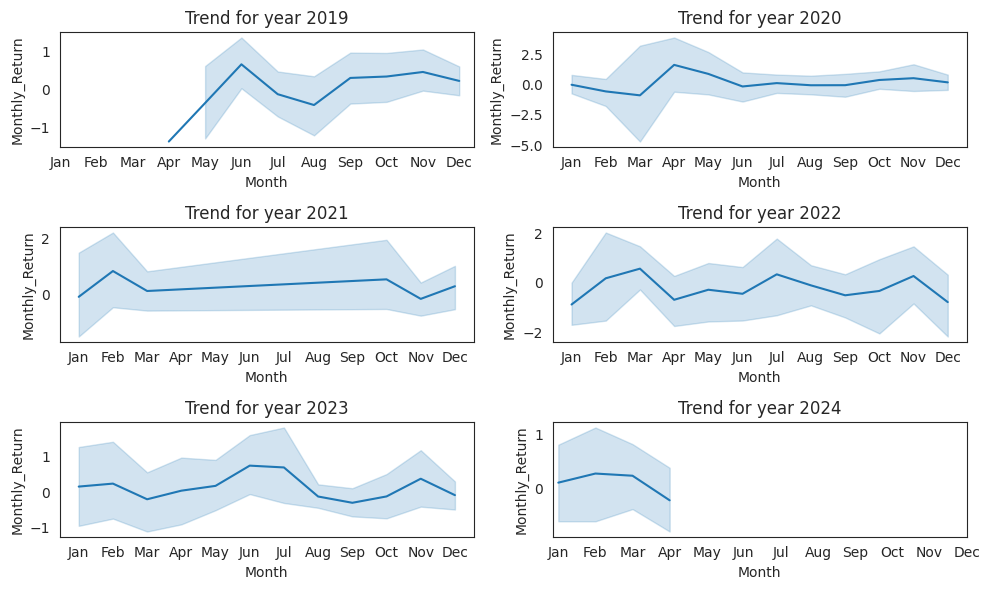

In [ ]:
month_names = [calendar.month_abbr[i] for i in range(1,13)]
ncols = 2  # Set the number of columns for subplots
nrows = math.ceil(len(years) / ncols)  # Calculate the number of rows based on the number of years
fig, axes = plt.subplots(nrows, ncols, figsize=(10,6))
for i, year in enumerate(years):
  row = i // ncols
  col = i % ncols
  sns.lineplot(data = zws[zws['Year'] == year],x = 'Month', y='Monthly_Return', ax = axes[row,col])
  axes[row,col].set_title(f"Trend for year {year}")
  axes[row,col].set_xticks(range(1,13))
  axes[row,col].set_xticklabels(month_names)

# Remove unused subplots
for i in range(len(years), nrows * ncols):
  row = i // ncols
  col = i % ncols
  fig.delaxes(axes[row,col])

plt.tight_layout()
plt.show()



## calculates the monthly average of 'close' prices, and then plots these averages over time.

<Axes: xlabel='Date'>

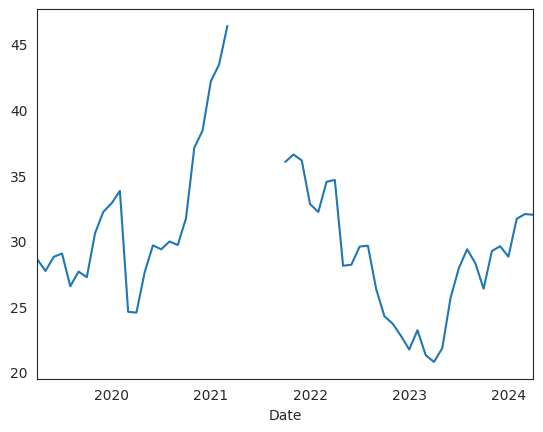

In [ ]:
zws_date_index = zws.copy()
zws_date_index.set_index("Date", inplace = True)

zws_date_index['Close'].resample("M").mean().plot()

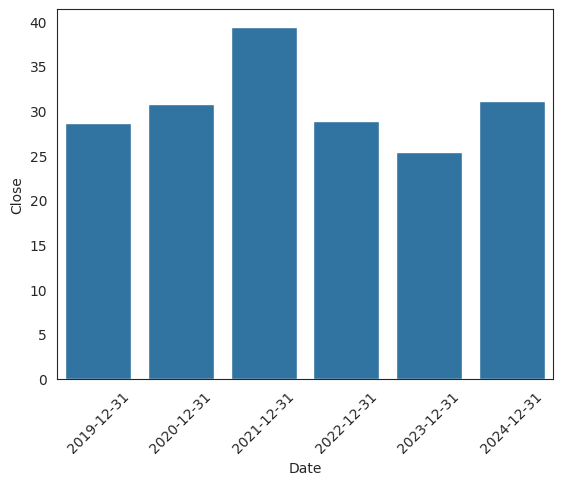

In [ ]:
zws_date_index = zws.copy()
zws_date_index.set_index("Date", inplace = True)

sns.barplot(zws_date_index['Close'].resample("Y").mean())
plt.xticks(rotation=45)
plt.show()

In [ ]:
zws_date_index.head(2)

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,Monthly_Return
Date,,,,,,,,,,
2019-04-30,29.030001,29.030001,28.350000,28.600000,27.566919,561600,2019,4,4,-1.379310
2019-05-02,28.309999,28.639999,28.110001,28.620001,27.586203,582800,2019,5,5,0.421056


## Check whether time series is stationary or not

In [ ]:
adf_test(zws_date_index,"Close")

ADF statistics: {:.2f}.format(results[0])
p-values: {:.2f}.format(results[1])
Critical Values: 
	{key}: {value:.2f}
The time series in non-statioanry
	{key}: {value:.2f}
The time series in non-statioanry
	{key}: {value:.2f}
The time series in non-statioanry


## Check for seasonality in data

ACF results are: [1.         0.98595354 0.97481471 0.96411717 0.95386944 0.94462574
 0.93448923 0.92551912 0.91547277 0.9047307  0.89357216 0.88318075
 0.87179128 0.86179743 0.85312411 0.84418147 0.83399226 0.82498651
 0.81637045 0.80882628 0.80080983 0.79331368 0.78672206 0.7799091
 0.77222155 0.76568392 0.76065284 0.75344485 0.74818058 0.74175946
 0.73572601] 

PACF results are: [ 1.00000000e+00  9.86882808e-01  1.04223409e-01  2.34326879e-02
  1.68209308e-02  3.84818488e-02 -2.97523020e-02  3.57266105e-02
 -3.74156517e-02 -3.88194668e-02 -3.17278536e-02  1.99429817e-02
 -4.69815899e-02  4.17860311e-02  5.41447457e-02 -3.11004469e-05
 -5.43869503e-02  4.39803179e-02  1.52615213e-02  4.41963070e-02
 -1.25877477e-02  1.73988309e-02  2.45179598e-02  7.50564736e-03
 -4.15505744e-02  3.77593883e-02  6.22738121e-02 -7.19464325e-02
  5.10779368e-02 -3.32831846e-02  3.40484252e-03], 



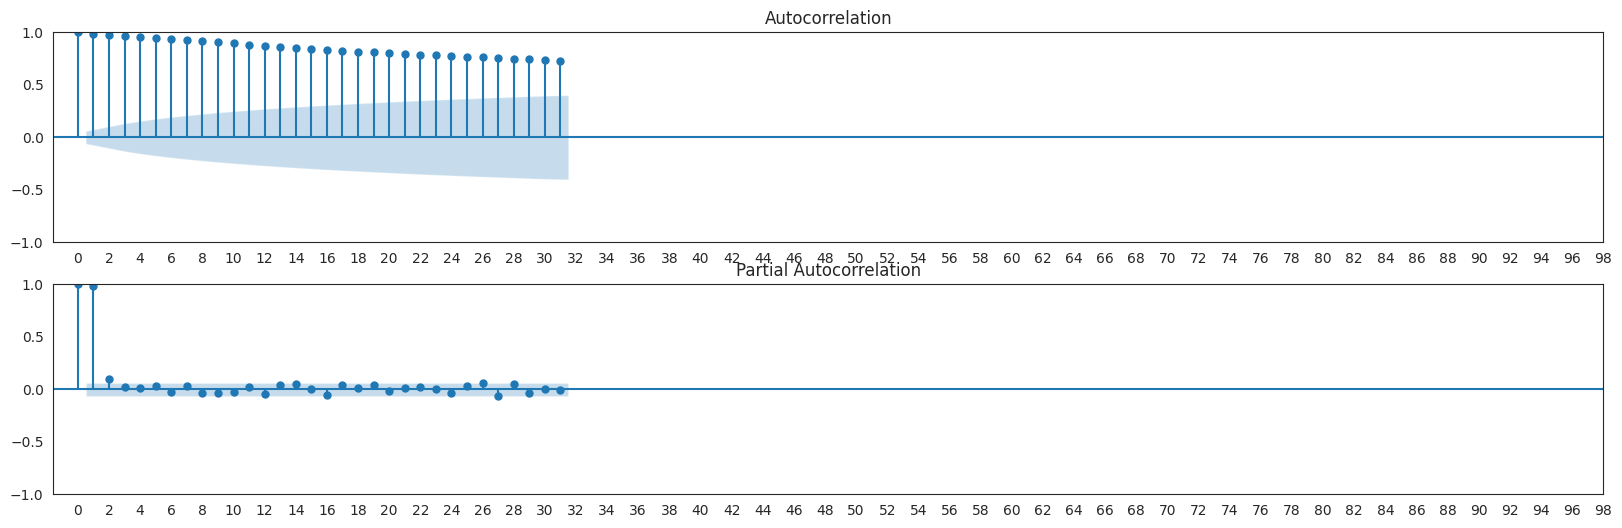

In [ ]:
plot_acf_pacf(zws_date_index,"Close")
plt.show()

## Trend Analysis
ACF Analysis:
- The ACF values gradually decrease and remain significant for many lags. This suggests a slow decay, indicating the presence of a trend.

PACF Analysis:
- The PACF values decrease gradually but show a significant spike at the first lag and a few significant spikes after that. This indicates the presence of a trend, as well.

## Seasonality Analysis:
ACF Analysis:
- There are no clear periodic spikes in the ACF values, suggesting the absence of strong seasonality.

PACF Analysis:
- Similarly, there are no clear periodic spikes in the PACF values, further indicating the absence of strong seasonality.

Trend: Trend appears to be present in the data.

Seasonality: No strong evidence of seasonality is observed.

Parameter Estimation: Tentative estimates for parameters could be AR(1), MA(1), and first-order differencing (d=1).